In [25]:
# Jupyter notebook in Jupytext format

## Feature Importance Analysis Notebook

This notebook performs comprehensive analysis of feature importance results from the consensus analysis, including:
- Jaccard stability similarity analysis comparing SHAP, MDI, and feature selection scores
- Convergence analysis with AUC calculation for tolerance drop curves
- SHAP signed values analysis for directional effects

## Initialisation

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\ode-biomarker-project


In [2]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [3]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [4]:
folder_name = "ThesisResult-FeatureImportanceConsensus"
exp_id = "v2_rf_k500_network_d3_split0.3"  # Without _importance_consensus suffix

# Create both the main folder and exp_id subfolder
main_folder = f"{path_loader.get_data_path()}data/results/{folder_name}"
exp_folder = f"{main_folder}/{exp_id}"

if not os.path.exists(main_folder):
    os.makedirs(main_folder)
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)

file_save_path = f"{exp_folder}/"

In [5]:
# Load saved feature importance consensus data
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Create a new report file for capturing print statements
print_report_path = f"{file_save_path}feature_importance_analysis_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

# Write header to the print report
print_report_file.write(f"# Feature Importance Analysis Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("This report captures all print statements from the feature importance analysis with proper formatting.\n\n")

def save_and_print(message, report_file=None, level="info"):
    """
    Print message to console and save to report file with proper formatting.
    
    Args:
        message: The message to print and save
        report_file: File object to save to (optional)
        level: Formatting level - "header", "section", "subsection", or "info"
    """
    # Print to console
    print(message)
    
    # Save to report with proper formatting
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:  # info level
            report_file.write(f"{message}\n\n")
    
    return message

## Data Loading and Preparation

In [6]:
save_and_print("## Data Loading and Preparation", print_report_file, level="section")

# Define conditions based on the feature_importance_consensus.py structure
model_name = "RandomForestRegressor"
k_value = 500
method_name = "mrmr_network_d3"
split_size = 0.3

conditions = [
    f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap",
    f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
]

# Load all available data files from the main folder where results are stored
data_files = {}

# The main folder where feature importance consensus results are stored
main_results_folder = f"{path_loader.get_data_path()}data/results/{folder_name}/"

for condition in conditions:
    condition_data = {}
    
    # Try to load each file type with fallback options
    file_types = [
        f"total_results_{condition}.pkl",
        f"meta_results_{condition}.pkl", 
        f"consensus_feature_importance_{condition}.pkl",
        f"iteration_feature_importance_{condition}.pkl",
        f"consensus_feature_importance_signed_{condition}.pkl",
        f"iteration_feature_importance_signed_{condition}.pkl"
    ]
    
    for file_type in file_types:
        file_path = f"{main_results_folder}{file_type}"
        if os.path.exists(file_path):
            try:
                condition_data[file_type.replace(f"_{condition}.pkl", "")] = pd.read_pickle(file_path)
                save_and_print(f"✓ Loaded {file_type}", print_report_file, level="info")
            except Exception as e:
                save_and_print(f"✗ Failed to load {file_type}: {e}", print_report_file, level="info")
        else:
            # Try alternative naming pattern if primary pattern fails
            alt_file_type = file_type.replace(f"_{condition}.pkl", f"_{condition}_importance_consensus.pkl")
            alt_file_path = f"{main_results_folder}{alt_file_type}"
            if os.path.exists(alt_file_path):
                try:
                    condition_data[file_type.replace(f"_{condition}.pkl", "")] = pd.read_pickle(alt_file_path)
                    save_and_print(f"✓ Loaded {alt_file_type} (alternative naming)", print_report_file, level="info")
                except Exception as e:
                    save_and_print(f"✗ Failed to load {alt_file_type}: {e}", print_report_file, level="info")
            else:
                save_and_print(f"✗ File not found: {file_type} or {alt_file_type}", print_report_file, level="info")
    
    data_files[condition] = condition_data

# Load comparison file
comparison_file = f"{main_results_folder}feature_importance_comparison_k{k_value}_split{split_size}.pkl"
if os.path.exists(comparison_file):
    comparison_df = pd.read_pickle(comparison_file)
    save_and_print("✓ Loaded feature importance comparison data", print_report_file, level="info")
else:
    comparison_df = None
    save_and_print("✗ Feature importance comparison file not found", print_report_file, level="info")

# Display available data summary
save_and_print("### Available Data Summary", print_report_file, level="subsection")
for condition, files in data_files.items():
    save_and_print(f"**{condition}**:", print_report_file, level="info")
    for file_type, data in files.items():
        if data is not None:
            save_and_print(f"  - {file_type}: {data.shape if hasattr(data, 'shape') else len(data)}", print_report_file, level="info")

## Data Loading and Preparation
✓ Loaded total_results_RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap.pkl
✓ Loaded iteration_feature_importance_RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap.pkl
✓ Loaded consensus_feature_importance_signed_RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap.pkl
✓ Loaded iteration_feature_importance_signed_RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap.pkl
✓ Loaded total_results_RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi.pkl
✓ Loaded meta_results_RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi.pkl
✓ Loaded consensus_feature_importance_RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi.pkl
✓ Loaded iteration_feature_importance_RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi.pkl
✗ File not found: consensus_fe

## Jaccard Stability Similarity Analysis

In [86]:
save_and_print("## Jaccard Stability Similarity Analysis", print_report_file, level="section")

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    if len(set1) == 0 and len(set2) == 0:
        return 1.0  # Both empty sets are considered identical
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def calculate_jaccard_stability_parallel(data_files, top_n=50, max_workers=None):
    """
    Calculate Jaccard similarity stability for different importance methods using parallel processing
    """
    stability_results = {}
    
    for condition, files in data_files.items():
        if 'iteration_feature_importance' not in files:
            continue
            
        iteration_df = files['iteration_feature_importance']
        
        # Get unique iterations
        iterations = iteration_df['iteration_rng'].unique()
        
        if len(iterations) < 2:
            save_and_print(f"Not enough iterations for {condition} (n={len(iterations)})", print_report_file, level="info")
            continue
        
        # Precompute top features for each iteration to avoid redundant calculations
        iteration_top_features = {}
        for iteration in iterations:
            iter_data = iteration_df[iteration_df['iteration_rng'] == iteration]
            top_features = set(iter_data.nlargest(top_n, 'importance_score')['feature_name'])
            iteration_top_features[iteration] = top_features
        
        # Generate all pairwise combinations for parallel processing
        from itertools import combinations
        iteration_pairs = list(combinations(iterations, 2))
        
        if len(iteration_pairs) == 0:
            continue
        
        # Use parallel processing for Jaccard similarity calculations
        try:
            from concurrent.futures import ProcessPoolExecutor
            import multiprocessing
            
            # Determine number of workers
            if max_workers is None:
                max_workers = min(multiprocessing.cpu_count(), len(iteration_pairs))
            
            # Function to calculate Jaccard similarity for a pair
            def calculate_pair_similarity(pair):
                i, j = pair
                top_i = iteration_top_features[i]
                top_j = iteration_top_features[j]
                return jaccard_similarity(top_i, top_j)
            
            # Process pairs in parallel
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                jaccard_similarities = list(executor.map(calculate_pair_similarity, iteration_pairs))
            
            save_and_print(f"✓ Processed {len(iteration_pairs)} pairs for {condition} using {max_workers} workers", print_report_file, level="info")
            
        except Exception as e:
            save_and_print(f"Parallel processing failed for {condition}: {e}. Falling back to sequential processing.", print_report_file, level="info")
            
            # Fallback to sequential processing
            jaccard_similarities = []
            for i, j in iteration_pairs:
                top_i = iteration_top_features[i]
                top_j = iteration_top_features[j]
                similarity = jaccard_similarity(top_i, top_j)
                jaccard_similarities.append(similarity)
        
        if jaccard_similarities:
            stability_results[condition] = {
                'mean_jaccard': np.mean(jaccard_similarities),
                'std_jaccard': np.std(jaccard_similarities),
                'n_comparisons': len(jaccard_similarities),
                'all_similarities': jaccard_similarities
            }
    
    return stability_results

def calculate_jaccard_stability(data_files, top_n=50):
    """
    Calculate Jaccard similarity stability for different importance methods
    (Wrapper function that uses parallel processing by default)
    """
    return calculate_jaccard_stability_parallel(data_files, top_n, max_workers=None)

def load_or_compute_stability(data_files, top_n_values, exp_id, file_save_path, force_recompute=False):
    """
    Load precomputed stability results or compute them if not available
    Includes data integrity checks and versioning
    """
    stability_file = f"{file_save_path}stability_results_{exp_id}.pkl"
    metadata_file = f"{file_save_path}stability_metadata_{exp_id}.json"
    
    # Check if results exist and should be loaded
    if not force_recompute and os.path.exists(stability_file) and os.path.exists(metadata_file):
        try:
            # Load metadata for validation
            import json
            import hashlib
            
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
            
            # Validate metadata structure and version
            current_top_n = sorted(top_n_values)
            saved_top_n = sorted(metadata.get('top_n_values', []))
            metadata_version = metadata.get('version', '1.0')
            
            # Check if we need to recompute due to version changes
            if metadata_version != '1.1':  # Current version
                save_and_print(f"Metadata version mismatch: saved={metadata_version}, current=1.1", print_report_file, level="info")
                save_and_print("Recomputing stability results due to version change...", print_report_file, level="info")
            elif current_top_n != saved_top_n:
                save_and_print(f"Top N values mismatch: current={current_top_n}, saved={saved_top_n}", print_report_file, level="info")
                save_and_print("Recomputing stability results...", print_report_file, level="info")
            else:
                # Additional data integrity check: verify file size and hash
                file_size = os.path.getsize(stability_file)
                if file_size == 0:
                    save_and_print("Stability results file is empty", print_report_file, level="info")
                    save_and_print("Recomputing stability results...", print_report_file, level="info")
                else:
                    # Load precomputed results
                    stability_results_all = pd.read_pickle(stability_file)
                    
                    # Verify the loaded data structure
                    if not isinstance(stability_results_all, dict):
                        save_and_print("Invalid stability results format", print_report_file, level="info")
                        save_and_print("Recomputing stability results...", print_report_file, level="info")
                    else:
                        # Check if all expected top_n values are present
                        missing_top_n = set(top_n_values) - set(stability_results_all.keys())
                        if missing_top_n:
                            save_and_print(f"Missing top_n values in loaded results: {missing_top_n}", print_report_file, level="info")
                            save_and_print("Recomputing stability results...", print_report_file, level="info")
                        else:
                            save_and_print(f"✓ Loaded precomputed stability results from {stability_file}", print_report_file, level="info")
                            save_and_print(f"  Generated: {metadata.get('timestamp', 'unknown')}", print_report_file, level="info")
                            save_and_print(f"  Version: {metadata_version}", print_report_file, level="info")
                            save_and_print(f"  File size: {file_size} bytes", print_report_file, level="info")
                            return stability_results_all
        
        except Exception as e:
            save_and_print(f"Error loading precomputed results: {e}", print_report_file, level="info")
            save_and_print("Recomputing stability results...", print_report_file, level="info")
    
    # Compute stability results
    save_and_print("Computing Jaccard stability results...", print_report_file, level="info")
    stability_results_all = {}
    
    for top_n in top_n_values:
        stability_results = calculate_jaccard_stability(data_files, top_n)
        stability_results_all[top_n] = stability_results
        
        save_and_print(f"### Jaccard Stability (Top {top_n} Features)", print_report_file, level="subsection")
        for condition, results in stability_results.items():
            save_and_print(f"**{condition}**: Mean Jaccard = {results['mean_jaccard']:.3f} ± {results['std_jaccard']:.3f} (n={results['n_comparisons']})", 
                          print_report_file, level="info")
    
    # Save results for future use with enhanced metadata
    try:
        # Save stability results
        pd.to_pickle(stability_results_all, stability_file)
        
        # Calculate file hash for integrity checking
        import hashlib
        with open(stability_file, 'rb') as f:
            file_hash = hashlib.md5(f.read()).hexdigest()
        
        # Enhanced metadata with versioning and integrity info
        metadata = {
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'top_n_values': top_n_values,
            'exp_id': exp_id,
            'conditions': list(data_files.keys()),
            'version': '1.1',  # Current version
            'file_size': os.path.getsize(stability_file),
            'file_hash': file_hash,
            'computation_method': 'parallel_processing',
            'data_integrity_checks': {
                'top_n_validation': True,
                'file_size_validation': True,
                'version_validation': True
            }
        }
        
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        save_and_print(f"✓ Saved stability results to {stability_file}", print_report_file, level="info")
        save_and_print(f"✓ Saved enhanced metadata to {metadata_file}", print_report_file, level="info")
        save_and_print(f"  Version: {metadata['version']}", print_report_file, level="info")
        save_and_print(f"  File size: {metadata['file_size']} bytes", print_report_file, level="info")
        save_and_print(f"  File hash: {metadata['file_hash'][:16]}...", print_report_file, level="info")
        
    except Exception as e:
        save_and_print(f"Warning: Could not save stability results: {e}", print_report_file, level="info")
    
    return stability_results_all

# Calculate Jaccard stability for different top N values with file-based persistence
top_n_values = [10, 25, 50, 100]
stability_results_all = load_or_compute_stability(data_files, top_n_values, exp_id, file_save_path, force_recompute=False)

## Jaccard Stability Similarity Analysis
Error loading precomputed results: Expecting value: line 1 column 1 (char 0)
Recomputing stability results...
Computing Jaccard stability results...
Parallel processing failed for RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap: Can't pickle local object 'calculate_jaccard_stability_parallel.<locals>.calculate_pair_similarity'. Falling back to sequential processing.
Parallel processing failed for RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi: Can't pickle local object 'calculate_jaccard_stability_parallel.<locals>.calculate_pair_similarity'. Falling back to sequential processing.
### Jaccard Stability (Top 10 Features)
**RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap**: Mean Jaccard = 0.314 ± 0.107 (n=30876)
**RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi**: Mean Jaccard = 0.361 ± 0.115 (n=30876)
Parallel processing failed for RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap: Can't pickle local obje

### Jaccard Stability Visualization

In [87]:
# Create publication-quality Jaccard stability plots
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14  # Large font for journal presentation
plt.rcParams['axes.linewidth'] = 1.5

# Create consistent color mapping
color_mapping = {
    'shap': '#1f77b4',  # Blue for SHAP
    'mdi': '#ff7f0e'    # Orange for MDI
}

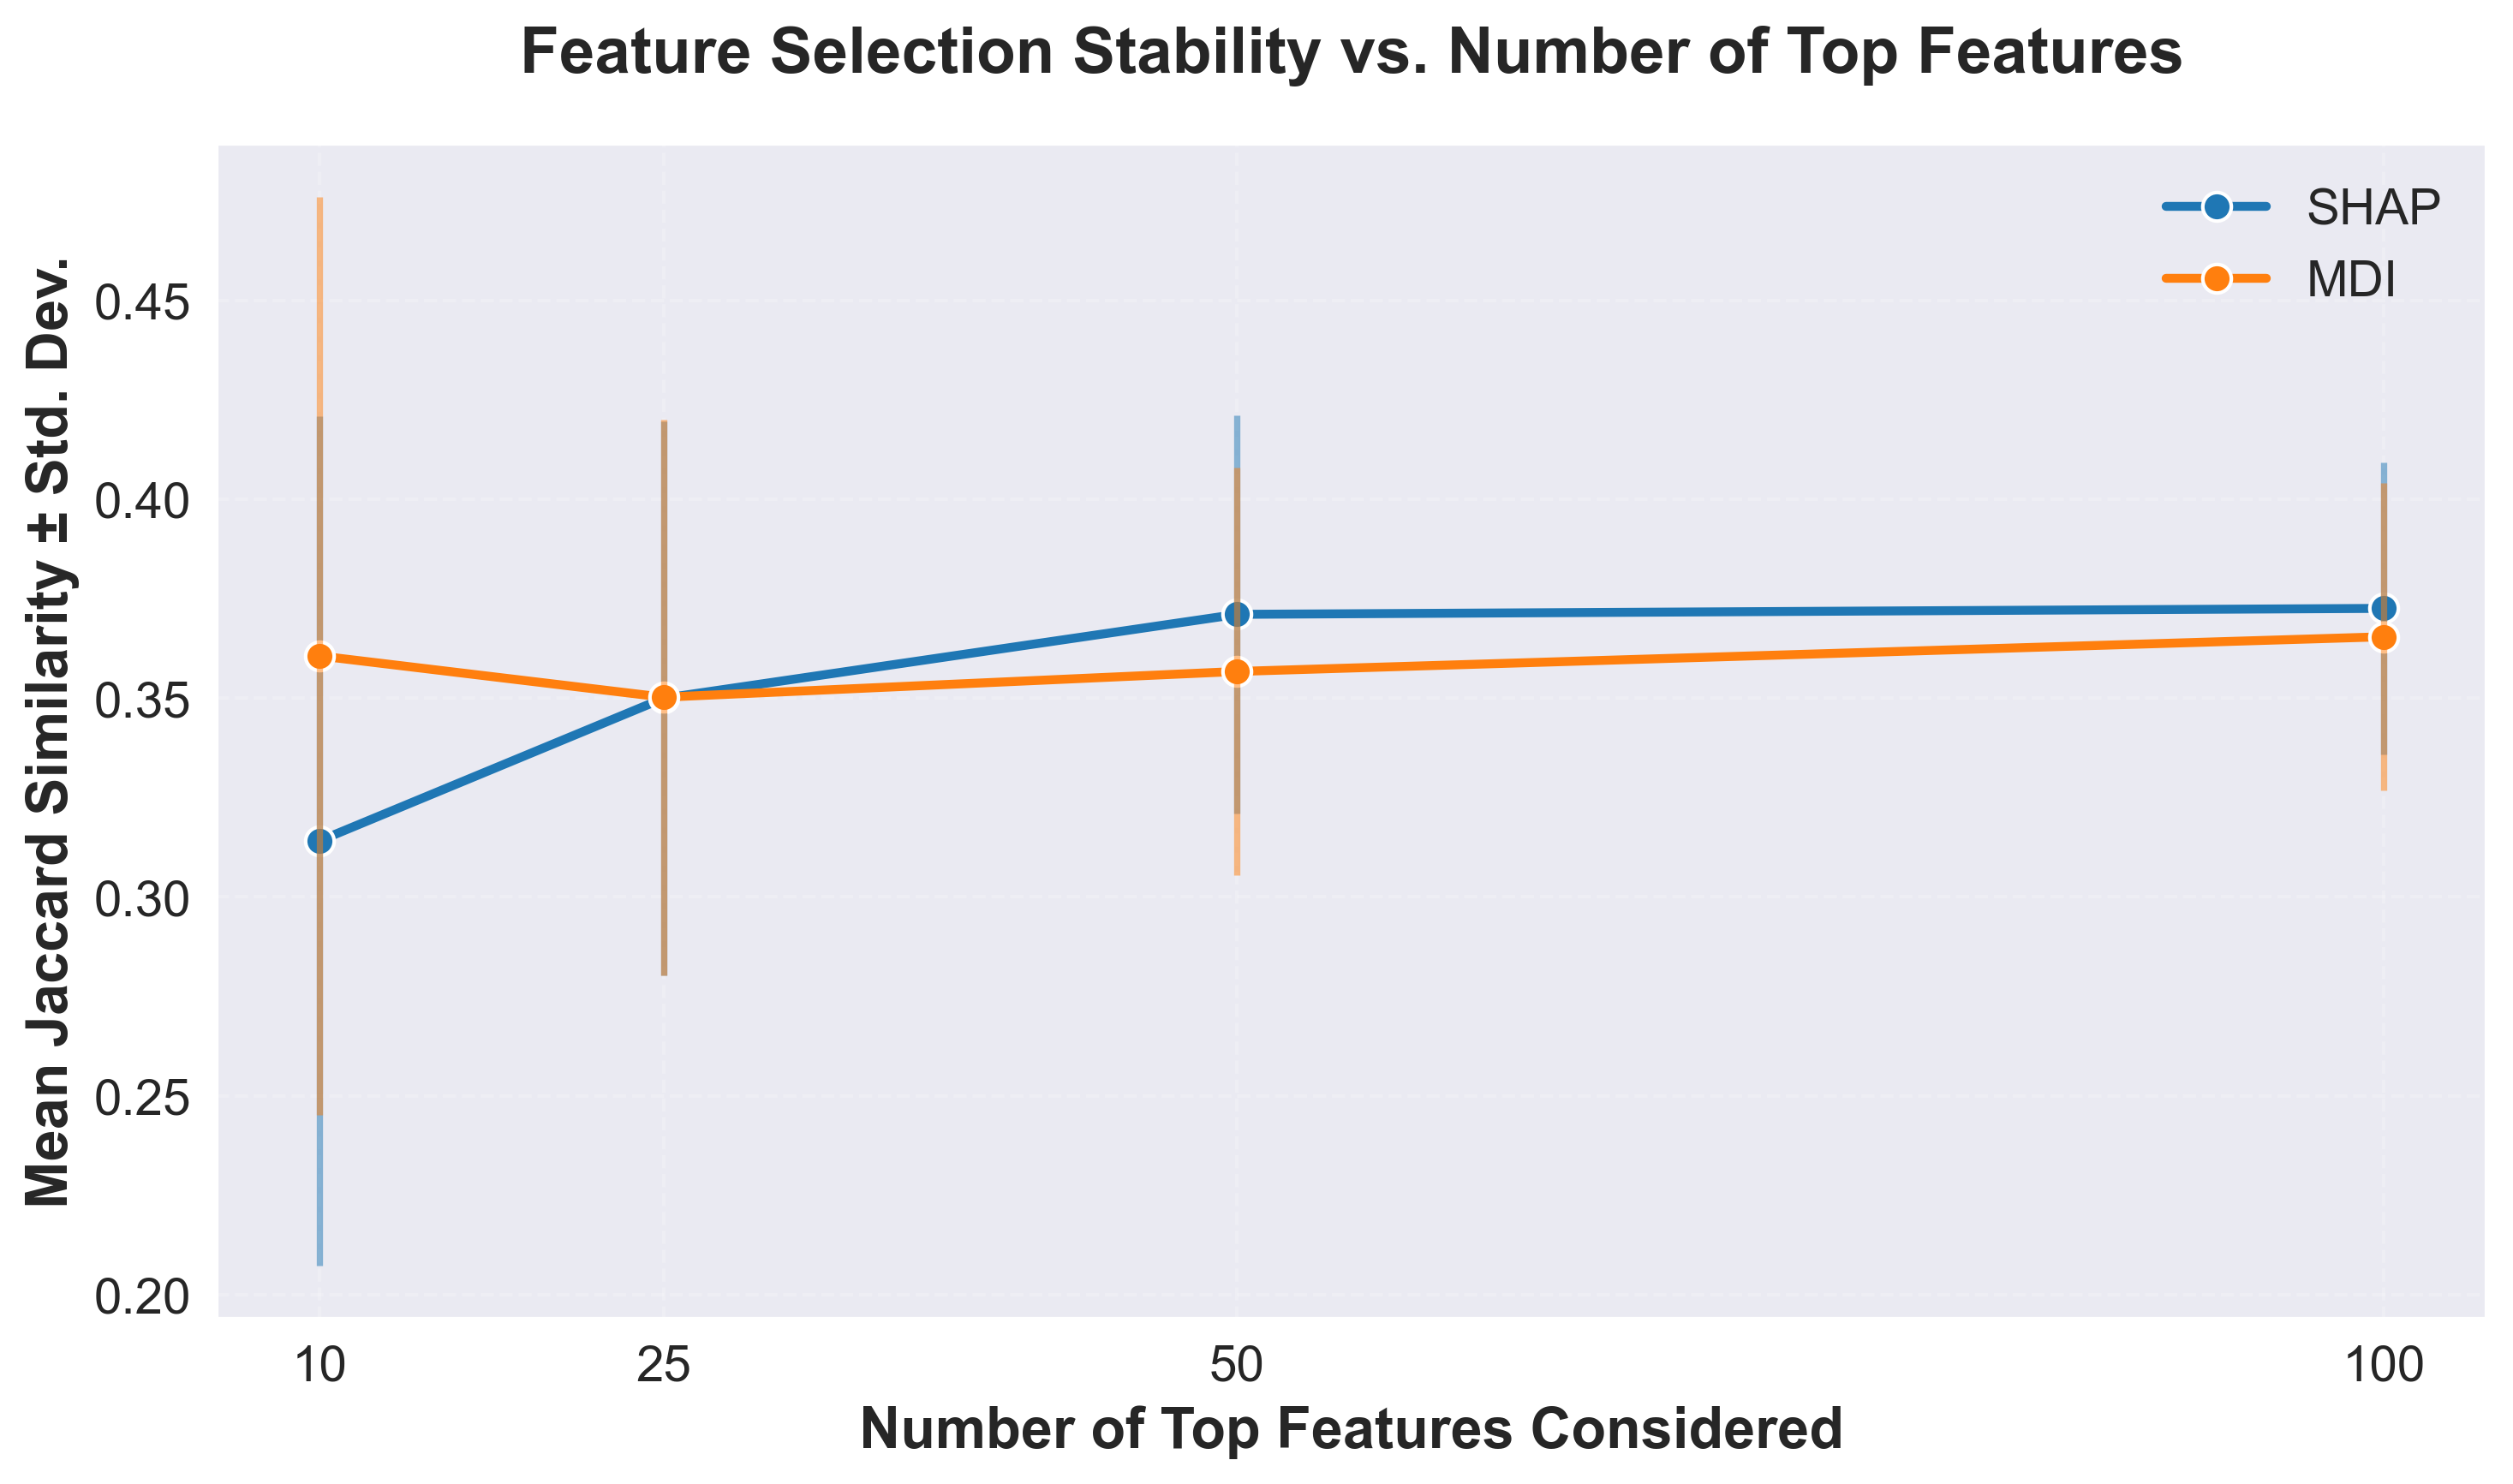

Created Jaccard stability vs top N features plot


'Created Jaccard stability vs top N features plot'

In [88]:

# Plot 1: Jaccard stability vs top N features
plt.figure(figsize=(10, 6), dpi=300)

for condition in stability_results_all[50].keys():  # Use results from top_n=50 as reference
    method_color = color_mapping['shap'] if 'shap' in condition else color_mapping['mdi']
    method_label = 'SHAP' if 'shap' in condition else 'MDI'
    
    mean_jaccards = []
    std_jaccards = []
    
    for top_n in top_n_values:
        if condition in stability_results_all[top_n]:
            mean_jaccards.append(stability_results_all[top_n][condition]['mean_jaccard'])
            std_jaccards.append(stability_results_all[top_n][condition]['std_jaccard'])
        else:
            mean_jaccards.append(np.nan)
            std_jaccards.append(np.nan)
    
    # Plot with error bars
    plt.plot(top_n_values, mean_jaccards, marker='o', linewidth=2.5, markersize=8,
             color=method_color, markeredgecolor='white', markeredgewidth=1,
             label=method_label)
    
    # Add error bars
    plt.errorbar(top_n_values, mean_jaccards, yerr=std_jaccards, 
                 fmt='none', ecolor=method_color, alpha=0.5, capsize=5)

plt.title('Feature Selection Stability vs. Number of Top Features', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of Top Features Considered', fontsize=16, fontweight='bold')
plt.ylabel('Mean Jaccard Similarity ± Std. Dev.', fontsize=16, fontweight='bold')
plt.xticks(top_n_values, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(fontsize=14, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}jaccard_stability_vs_top_n_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

save_and_print("Created Jaccard stability vs top N features plot", print_report_file, level="info")

### Statistical Comparison of Stability

In [89]:
save_and_print("### Statistical Comparison of Stability Methods", print_report_file, level="subsection")

# Compare SHAP vs MDI stability using non-parametric tests
shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"

if shap_condition in stability_results_all[50] and mdi_condition in stability_results_all[50]:
    shap_similarities = stability_results_all[50][shap_condition]['all_similarities']
    mdi_similarities = stability_results_all[50][mdi_condition]['all_similarities']
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_value_mw = mannwhitneyu(shap_similarities, mdi_similarities)
    
    # Wilcoxon signed-rank test (for paired data approximation)
    # Since we have different numbers of comparisons, we'll use the first min(n1, n2) pairs
    min_len = min(len(shap_similarities), len(mdi_similarities))
    w_stat, p_value_wilcoxon = wilcoxon(shap_similarities[:min_len], mdi_similarities[:min_len])
    
    save_and_print("**Statistical Comparison (Top 50 Features):**", print_report_file, level="info")
    save_and_print(f"SHAP mean stability: {np.mean(shap_similarities):.3f} ± {np.std(shap_similarities):.3f}", print_report_file, level="info")
    save_and_print(f"MDI mean stability: {np.mean(mdi_similarities):.3f} ± {np.std(mdi_similarities):.3f}", print_report_file, level="info")
    save_and_print(f"Mann-Whitney U test: U={u_stat:.1f}, p={p_value_mw:.4f}", print_report_file, level="info")
    save_and_print(f"Wilcoxon signed-rank test: W={w_stat:.1f}, p={p_value_wilcoxon:.4f}", print_report_file, level="info")
    
    if p_value_mw < 0.05:
        save_and_print("**Significant difference found between SHAP and MDI stability**", print_report_file, level="info")
    else:
        save_and_print("No significant difference between SHAP and MDI stability", print_report_file, level="info")

### Statistical Comparison of Stability Methods
**Statistical Comparison (Top 50 Features):**
SHAP mean stability: 0.371 ± 0.050
MDI mean stability: 0.357 ± 0.051
Mann-Whitney U test: U=553751480.0, p=0.0000
Wilcoxon signed-rank test: W=147460736.5, p=0.0000
**Significant difference found between SHAP and MDI stability**


## Convergence Analysis with AUC Calculation

In [90]:
from numpy import trapz # noqa: E402
save_and_print("## Convergence Analysis with AUC Calculation", print_report_file, level="section")

def calculate_convergence_auc(meta_df):
    """
    Calculate AUC for tolerance convergence curve
    Lower AUC indicates faster/better convergence (higher stability)
    """
    if meta_df is None or len(meta_df) < 2:
        return np.nan, np.nan
    
    # Normalize iteration numbers to [0, 1] for AUC calculation
    iterations = meta_df['iteration'].values
    normalized_iterations = iterations / iterations.max()
    
    # Use current tolerance values
    tolerance_values = meta_df['current_tol'].values
    
    # Calculate AUC using trapezoidal rule
    auc = trapz(tolerance_values, normalized_iterations)
    
    # Also calculate convergence rate (slope of tolerance decrease)
    if len(tolerance_values) > 1:
        # Use log scale for better rate estimation
        log_tolerance = np.log(tolerance_values + 1e-10)  # Add small constant to avoid log(0)
        convergence_rate = np.polyfit(normalized_iterations[:len(log_tolerance)], log_tolerance, 1)[0]
    else:
        convergence_rate = np.nan
    
    return auc, convergence_rate

# Calculate convergence metrics for each condition
convergence_results = {}

for condition, files in data_files.items():
    if 'meta_results' not in files:
        continue
    
    meta_df = files['meta_results']
    auc, convergence_rate = calculate_convergence_auc(meta_df)
    
    convergence_results[condition] = {
        'auc': auc,
        'convergence_rate': convergence_rate,
        'final_iteration': meta_df['iteration'].iloc[-1] if len(meta_df) > 0 else 0,
        'final_tolerance': meta_df['current_tol'].iloc[-1] if len(meta_df) > 0 else np.nan
    }
    
    save_and_print(f"**{condition}**:", print_report_file, level="info")
    save_and_print(f"  - AUC: {auc:.4f} (lower = better convergence)", print_report_file, level="info")
    save_and_print(f"  - Convergence rate: {convergence_rate:.4f}", print_report_file, level="info")
    save_and_print(f"  - Final iteration: {convergence_results[condition]['final_iteration']}", print_report_file, level="info")
    save_and_print(f"  - Final tolerance: {convergence_results[condition]['final_tolerance']:.6f}", print_report_file, level="info")

## Convergence Analysis with AUC Calculation
**RandomForestRegressor_k500_mrmr_network_d3_split0.3_shap**:
  - AUC: 0.0097 (lower = better convergence)
  - Convergence rate: -2.9325
  - Final iteration: 249
  - Final tolerance: 0.001677
**RandomForestRegressor_k500_mrmr_network_d3_split0.3_mdi**:
  - AUC: 0.0090 (lower = better convergence)
  - Convergence rate: -2.9355
  - Final iteration: 249
  - Final tolerance: 0.001581


### Convergence Visualization - Separate Plots

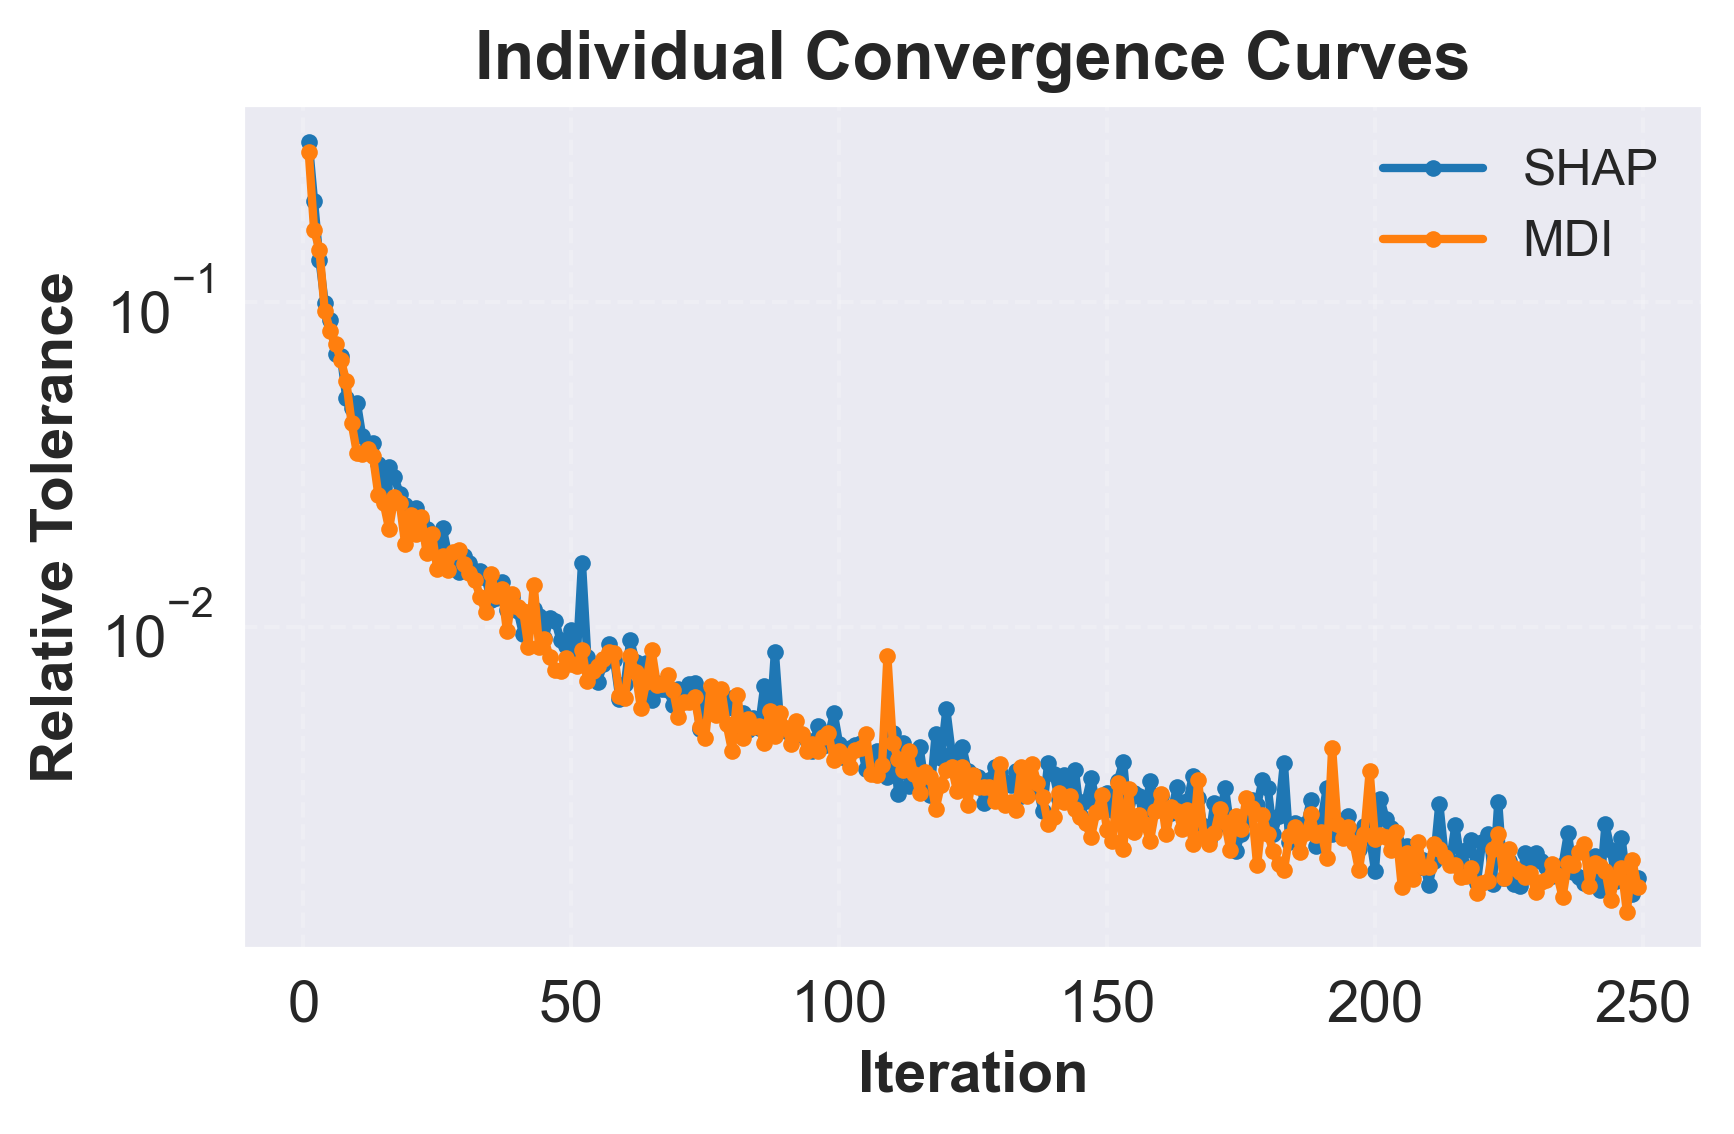

Created individual convergence curves plot


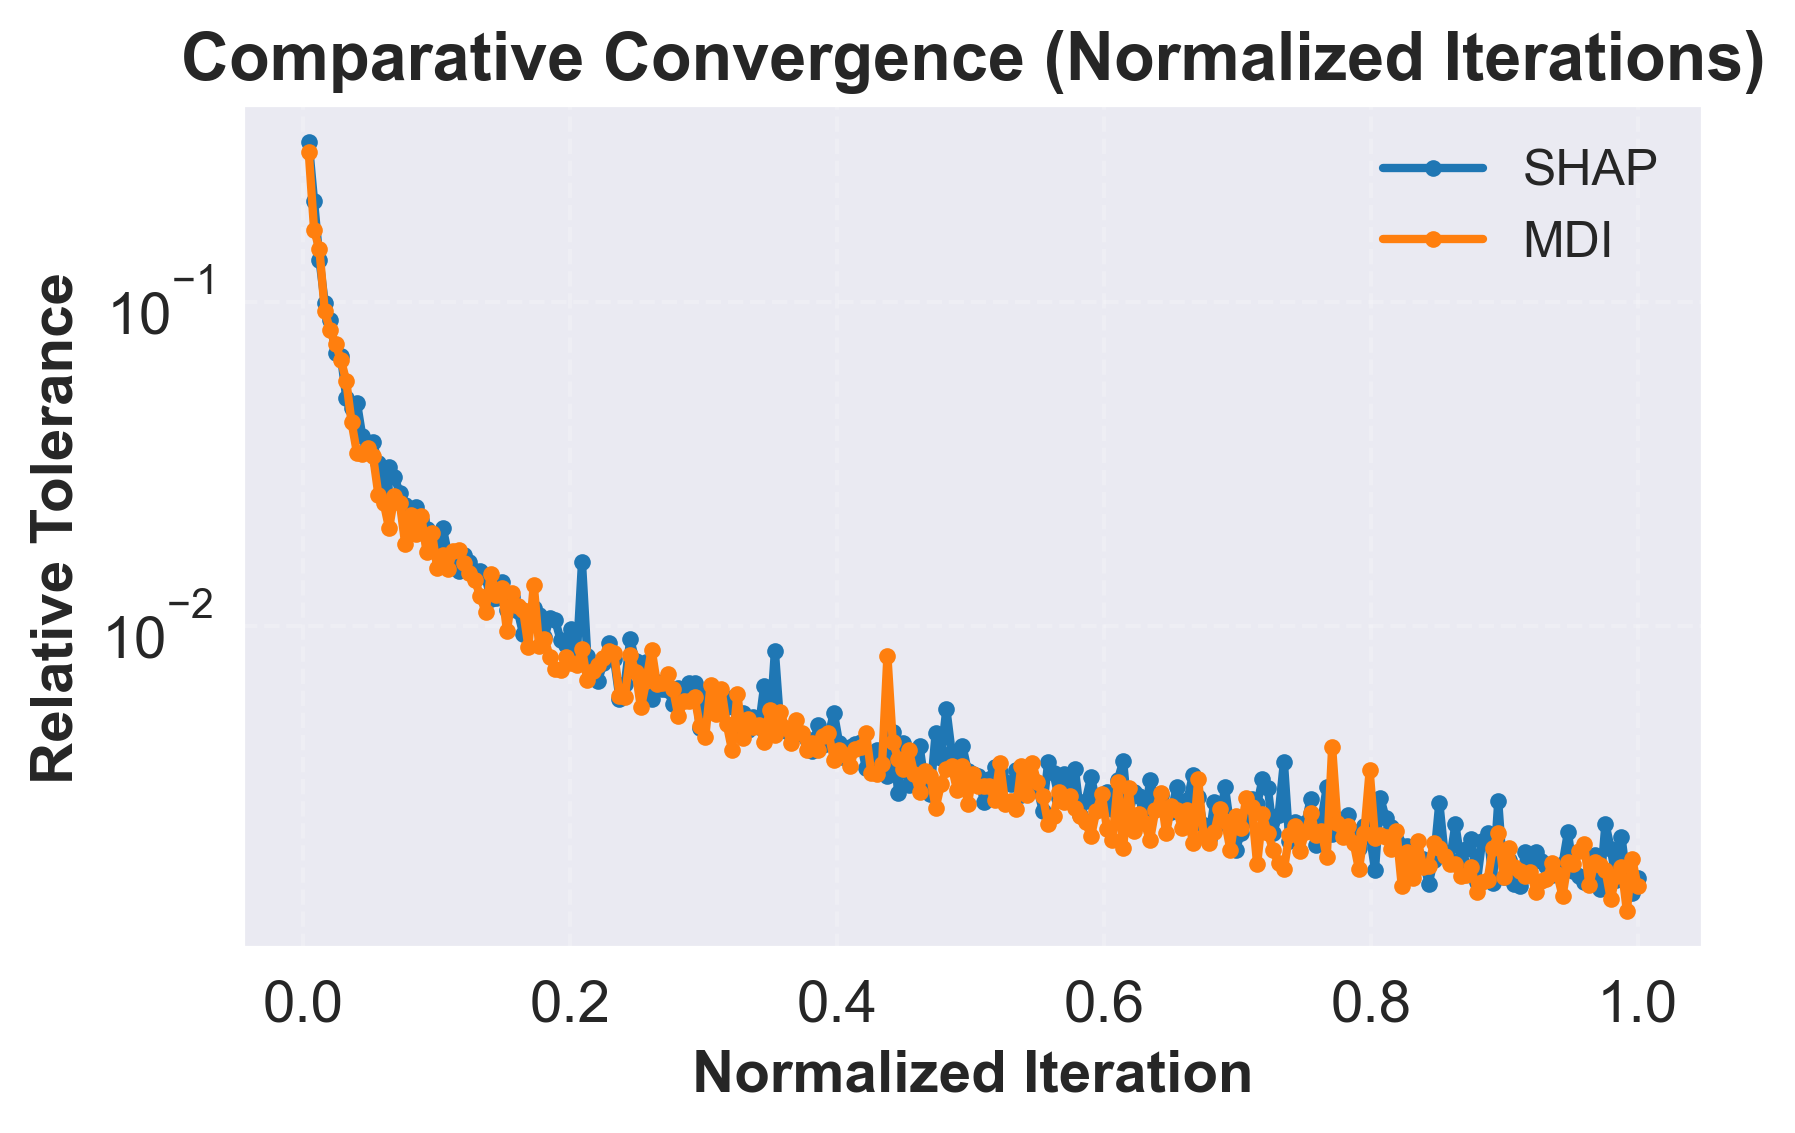

Created comparative convergence plot


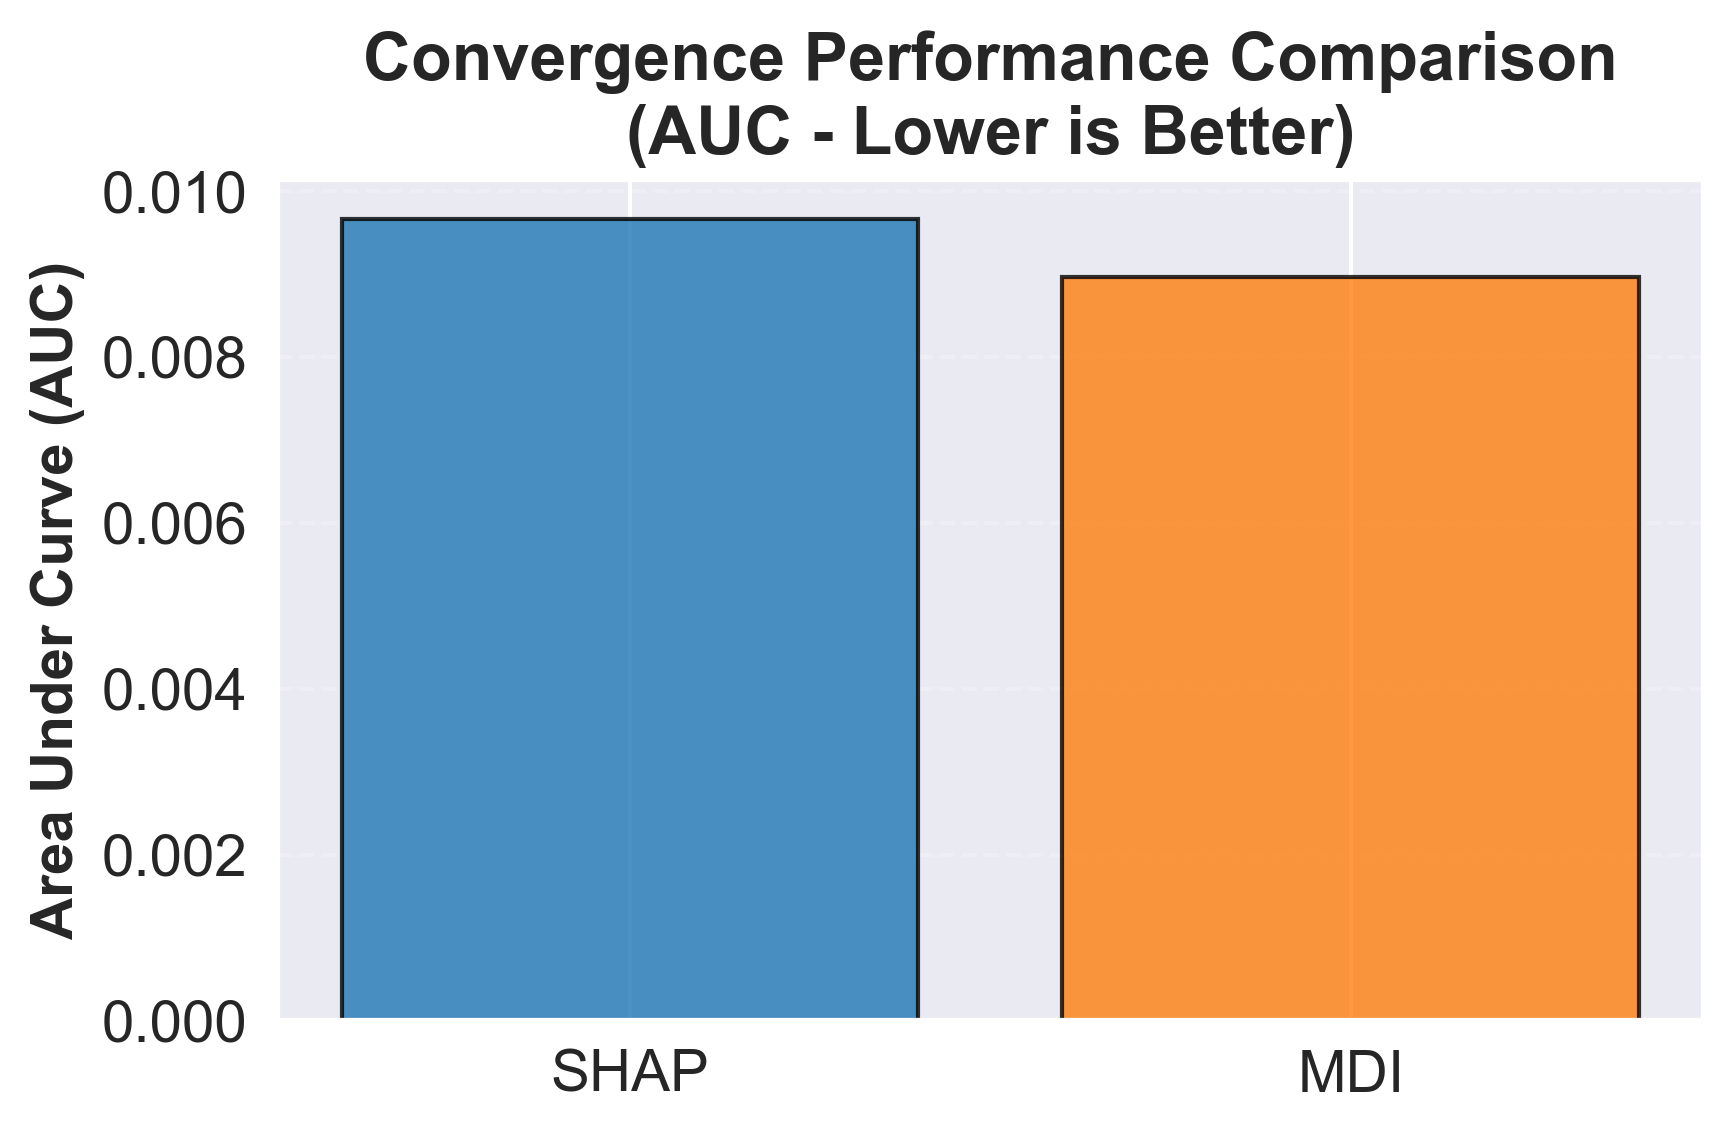

Created convergence AUC comparison plot


'Created convergence AUC comparison plot'

In [91]:
# Create publication-quality convergence plots as separate figures
plt.rcParams['font.size'] = 14
plt.rcParams["xtick.labelsize"] = 14  # Set x-tick size
plt.rcParams["ytick.labelsize"] = 14  # Set y-tick size

# Plot 1: Individual convergence curves (separate file)
plt.figure(figsize=(6, 4), dpi=300)

for condition, files in data_files.items():
    if 'meta_results' not in files:
        continue
    
    meta_df = files['meta_results']
    method_color = color_mapping['shap'] if 'shap' in condition else color_mapping['mdi']
    method_label = 'SHAP' if 'shap' in condition else 'MDI'
    
    plt.plot(meta_df['iteration'], meta_df['current_tol'], 
             marker='o', linewidth=2, markersize=4,
             color=method_color, label=method_label)

plt.title('Individual Convergence Curves', fontsize=16, fontweight='bold')
plt.xlabel('Iteration', fontsize=14, fontweight='bold')
plt.ylabel('Relative Tolerance', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"{file_save_path}individual_convergence_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

save_and_print("Created individual convergence curves plot", print_report_file, level="info")

# Plot 2: Comparative convergence (normalized iterations) - separate file
plt.figure(figsize=(6, 4), dpi=300)

for condition, files in data_files.items():
    if 'meta_results' not in files:
        continue
    
    meta_df = files['meta_results']
    method_color = color_mapping['shap'] if 'shap' in condition else color_mapping['mdi']
    method_label = 'SHAP' if 'shap' in condition else 'MDI'
    
    # Normalize iterations to [0, 1]
    normalized_iterations = meta_df['iteration'] / meta_df['iteration'].max()
    
    plt.plot(normalized_iterations, meta_df['current_tol'], 
             marker='o', linewidth=2, markersize=4,
             color=method_color, label=method_label)

plt.title('Comparative Convergence (Normalized Iterations)', fontsize=16, fontweight='bold')
plt.xlabel('Normalized Iteration', fontsize=14, fontweight='bold')
plt.ylabel('Relative Tolerance', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"{file_save_path}comparative_convergence_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

save_and_print("Created comparative convergence plot", print_report_file, level="info")

# Plot 3: Convergence AUC comparison (separate file)
plt.figure(figsize=(6, 4), dpi=300)

methods = []
auc_values = []

for condition in conditions:
    if condition in convergence_results:
        methods.append('SHAP' if 'shap' in condition else 'MDI')
        auc_values.append(convergence_results[condition]['auc'])

bars = plt.bar(methods, auc_values, 
               color=[color_mapping['shap'] if m == 'SHAP' else color_mapping['mdi'] for m in methods],
               alpha=0.8, edgecolor='black', linewidth=1, capsize=10)

plt.title('Convergence Performance Comparison\n(AUC - Lower is Better)', fontsize=16, fontweight='bold')
plt.ylabel('Area Under Curve (AUC)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig(f"{file_save_path}convergence_auc_comparison_{exp_id}.png", dpi=300, bbox_inches='tight')
plt.show()

save_and_print("Created convergence AUC comparison plot", print_report_file, level="info")

### AUC Comparison Statistical Analysis

In [92]:
save_and_print("### AUC Comparison Statistical Analysis", print_report_file, level="subsection")

if len(convergence_results) >= 2:
    # Extract AUC values for statistical comparison
    auc_values = []
    method_labels = []
    
    for condition, results in convergence_results.items():
        auc_values.append(results['auc'])
        method_labels.append('SHAP' if 'shap' in condition else 'MDI')
    
    # Mann-Whitney U test for AUC comparison
    shap_auc = [auc for auc, label in zip(auc_values, method_labels) if label == 'SHAP']
    mdi_auc = [auc for auc, label in zip(auc_values, method_labels) if label == 'MDI']
    
    if len(shap_auc) > 0 and len(mdi_auc) > 0:
        u_stat_auc, p_value_auc = mannwhitneyu(shap_auc, mdi_auc)
        
        save_and_print("**AUC Statistical Comparison:**", print_report_file, level="info")
        save_and_print(f"SHAP mean AUC: {np.mean(shap_auc):.4f} ± {np.std(shap_auc):.4f}", print_report_file, level="info")
        save_and_print(f"MDI mean AUC: {np.mean(mdi_auc):.4f} ± {np.std(mdi_auc):.4f}", print_report_file, level="info")
        save_and_print(f"Mann-Whitney U test: U={u_stat_auc:.1f}, p={p_value_auc:.4f}", print_report_file, level="info")
        
        if p_value_auc < 0.05:
            better_method = "SHAP" if np.mean(shap_auc) < np.mean(mdi_auc) else "MDI"
            save_and_print(f"**{better_method} shows significantly better convergence (lower AUC)**", print_report_file, level="info")
        else:
            save_and_print("No significant difference in convergence AUC", print_report_file, level="info")

### AUC Comparison Statistical Analysis
**AUC Statistical Comparison:**
SHAP mean AUC: 0.0097 ± 0.0000
MDI mean AUC: 0.0090 ± 0.0000
Mann-Whitney U test: U=1.0, p=1.0000
No significant difference in convergence AUC


## SHAP Signed Values Analysis

In [13]:
save_and_print("## SHAP Signed Values Analysis", print_report_file, level="section")

def analyze_shap_signed_values(data_files):
    """
    Analyze directional effects of features using signed SHAP values
    """
    shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
    
    if shap_condition not in data_files:
        save_and_print("SHAP condition data not available for signed values analysis", print_report_file, level="info")
        return None
    
    files = data_files[shap_condition]
    
    if 'consensus_feature_importance_signed' not in files:
        save_and_print("Signed SHAP values not available", print_report_file, level="info")
        return None
    
    signed_consensus = files['consensus_feature_importance_signed']
    
    # Analyze directional effects
    positive_effects = signed_consensus[signed_consensus['mean_importance_signed'] > 0]
    negative_effects = signed_consensus[signed_consensus['mean_importance_signed'] < 0]
    neutral_effects = signed_consensus[signed_consensus['mean_importance_signed'] == 0]
    
    save_and_print("### SHAP Signed Values Summary", print_report_file, level="subsection")
    save_and_print(f"Total features with signed values: {len(signed_consensus)}", print_report_file, level="info")
    save_and_print(f"Features with positive effect: {len(positive_effects)}", print_report_file, level="info")
    save_and_print(f"Features with negative effect: {len(negative_effects)}", print_report_file, level="info")
    save_and_print(f"Features with neutral effect: {len(neutral_effects)}", print_report_file, level="info")
    
    # Top positive and negative effects
    save_and_print("### Top 10 Positive Effects", print_report_file, level="subsection")
    top_positive = positive_effects.nlargest(10, 'mean_importance_signed')[['mean_importance_signed', 'std_importance_signed', 'occurrence_count']]
    save_and_print(top_positive.to_string(), print_report_file, level="info")
    
    save_and_print("### Top 10 Negative Effects", print_report_file, level="subsection")
    top_negative = negative_effects.nsmallest(10, 'mean_importance_signed')[['mean_importance_signed', 'std_importance_signed', 'occurrence_count']]
    save_and_print(top_negative.to_string(), print_report_file, level="info")
    
    return {
        'signed_consensus': signed_consensus,
        'positive_effects': positive_effects,
        'negative_effects': negative_effects,
        'neutral_effects': neutral_effects
    }

# Perform SHAP signed values analysis
shap_signed_analysis = analyze_shap_signed_values(data_files)

## SHAP Signed Values Analysis
### SHAP Signed Values Summary
Total features with signed values: 923
Features with positive effect: 437
Features with negative effect: 474
Features with neutral effect: 12
### Top 10 Positive Effects
                    mean_importance_signed  std_importance_signed  occurrence_count
feature_name                                                                       
Q92608;DOCK2_HUMAN                0.005893               0.016235               252
Q13422;IKZF1_HUMAN                0.005126               0.013042               252
P18031;PTN1_HUMAN                 0.004654               0.005696               252
O94826;TOM70_HUMAN                0.003177               0.002892               244
P33316;DUT_HUMAN                  0.002910               0.003623               252
Q13951;PEBB_HUMAN                 0.002724               0.003246               252
P23921;RIR1_HUMAN                 0.002615               0.002433               252
Q15003;CND2_

### SHAP Directional Features Export

In [14]:
def export_shap_directional_features(shap_signed_analysis, file_save_path, exp_id):
    """
    Export SHAP features with positive and negative directional effects to separate CSV files
    following the same format as existing feature importance exports for compatibility
    """
    if shap_signed_analysis is None:
        save_and_print("No SHAP signed analysis data available for export", print_report_file, level="info")
        return None
    
    positive_effects = shap_signed_analysis['positive_effects']
    negative_effects = shap_signed_analysis['negative_effects']
    
    # Rename columns for compatibility with existing exports
    positive_export = positive_effects[['mean_importance_signed', 'std_importance_signed', 'occurrence_count']].copy()
    negative_export = negative_effects[['mean_importance_signed', 'std_importance_signed', 'occurrence_count']].copy()
    
    # Rename columns to match existing format
    positive_export = positive_export.rename(columns={
        'mean_importance_signed': 'mean_importance',
        'std_importance_signed': 'std_importance'
    })
    negative_export = negative_export.rename(columns={
        'mean_importance_signed': 'mean_importance',
        'std_importance_signed': 'std_importance'
    })
    
    # Convert negative values to absolute values for negative effects export
    negative_export['mean_importance'] = negative_export['mean_importance'].abs()
    
    # Sort by absolute value of mean_importance (most impactful first)
    positive_export['abs_importance'] = positive_export['mean_importance'].abs()
    negative_export['abs_importance'] = negative_export['mean_importance'].abs()
    
    positive_export = positive_export.sort_values('abs_importance', ascending=False)
    negative_export = negative_export.sort_values('abs_importance', ascending=False)
    
    # Remove the temporary abs_importance column before export
    positive_export = positive_export.drop('abs_importance', axis=1)
    negative_export = negative_export.drop('abs_importance', axis=1)
    
    # Export positive effects
    positive_csv_path = f"{file_save_path}shap_positive_effects_{exp_id}.csv"
    positive_export.to_csv(positive_csv_path)
    
    # Export negative effects  
    negative_csv_path = f"{file_save_path}shap_negative_effects_{exp_id}.csv"
    negative_export.to_csv(negative_csv_path)
    
    save_and_print("### SHAP Directional Features Export", print_report_file, level="subsection")
    save_and_print(f"✓ Positive effects exported to: {positive_csv_path}", print_report_file, level="info")
    save_and_print(f"  - Features with positive effect: {len(positive_export)}", print_report_file, level="info")
    save_and_print(f"✓ Negative effects exported to: {negative_csv_path}", print_report_file, level="info")
    save_and_print(f"  - Features with negative effect: {len(negative_export)}", print_report_file, level="info")
    save_and_print("  - Column names: mean_importance, std_importance, occurrence_count (compatible with existing exports)", print_report_file, level="info")
    
    return positive_csv_path, negative_csv_path

# Export SHAP directional features
shap_directional_export = export_shap_directional_features(shap_signed_analysis, file_save_path, exp_id)

### SHAP Directional Features Export
✓ Positive effects exported to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult-FeatureImportanceConsensus/v2_rf_k500_network_d3_split0.3/shap_positive_effects_v2_rf_k500_network_d3_split0.3.csv
  - Features with positive effect: 437
✓ Negative effects exported to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult-FeatureImportanceConsensus/v2_rf_k500_network_d3_split0.3/shap_negative_effects_v2_rf_k500_network_d3_split0.3.csv
  - Features with negative effect: 474
  - Column names: mean_importance, std_importance, occurrence_count (compatible with existing exports)


### SHAP Signed Values Visualization

SHAP signed values distribution: 437 positive, 474 negative, 12 neutral


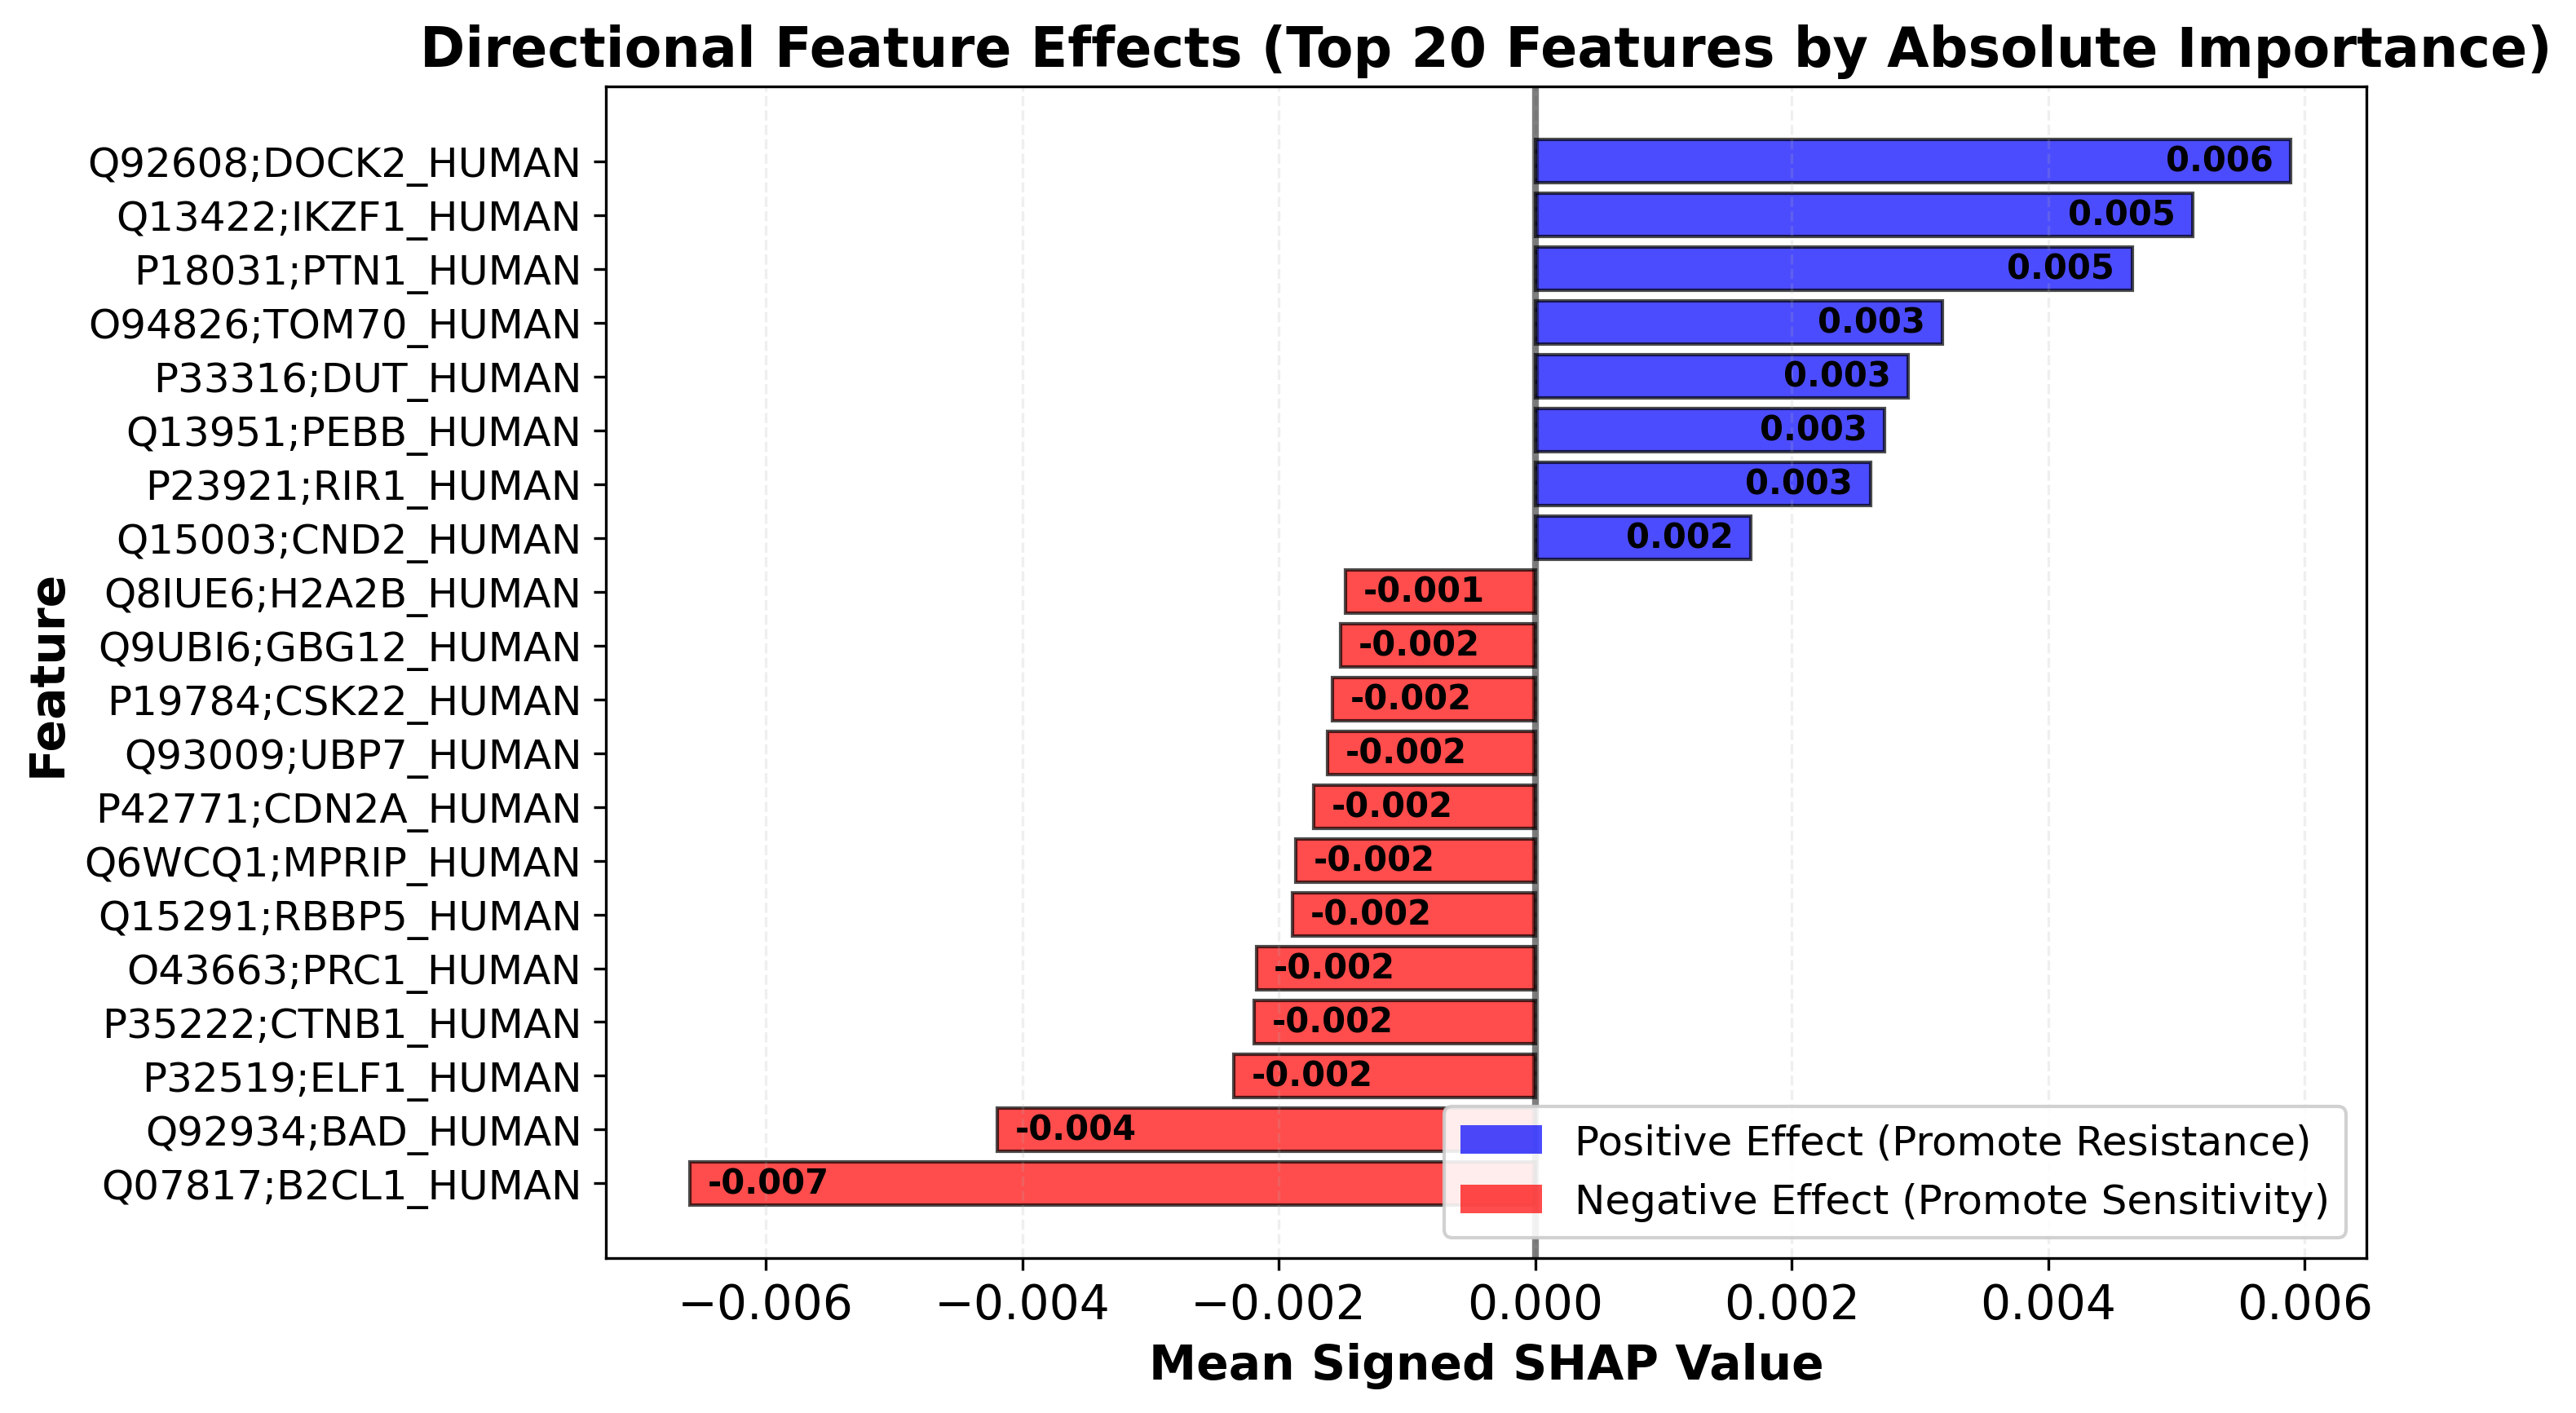

Created SHAP signed values visualization showing both positive and negative effects


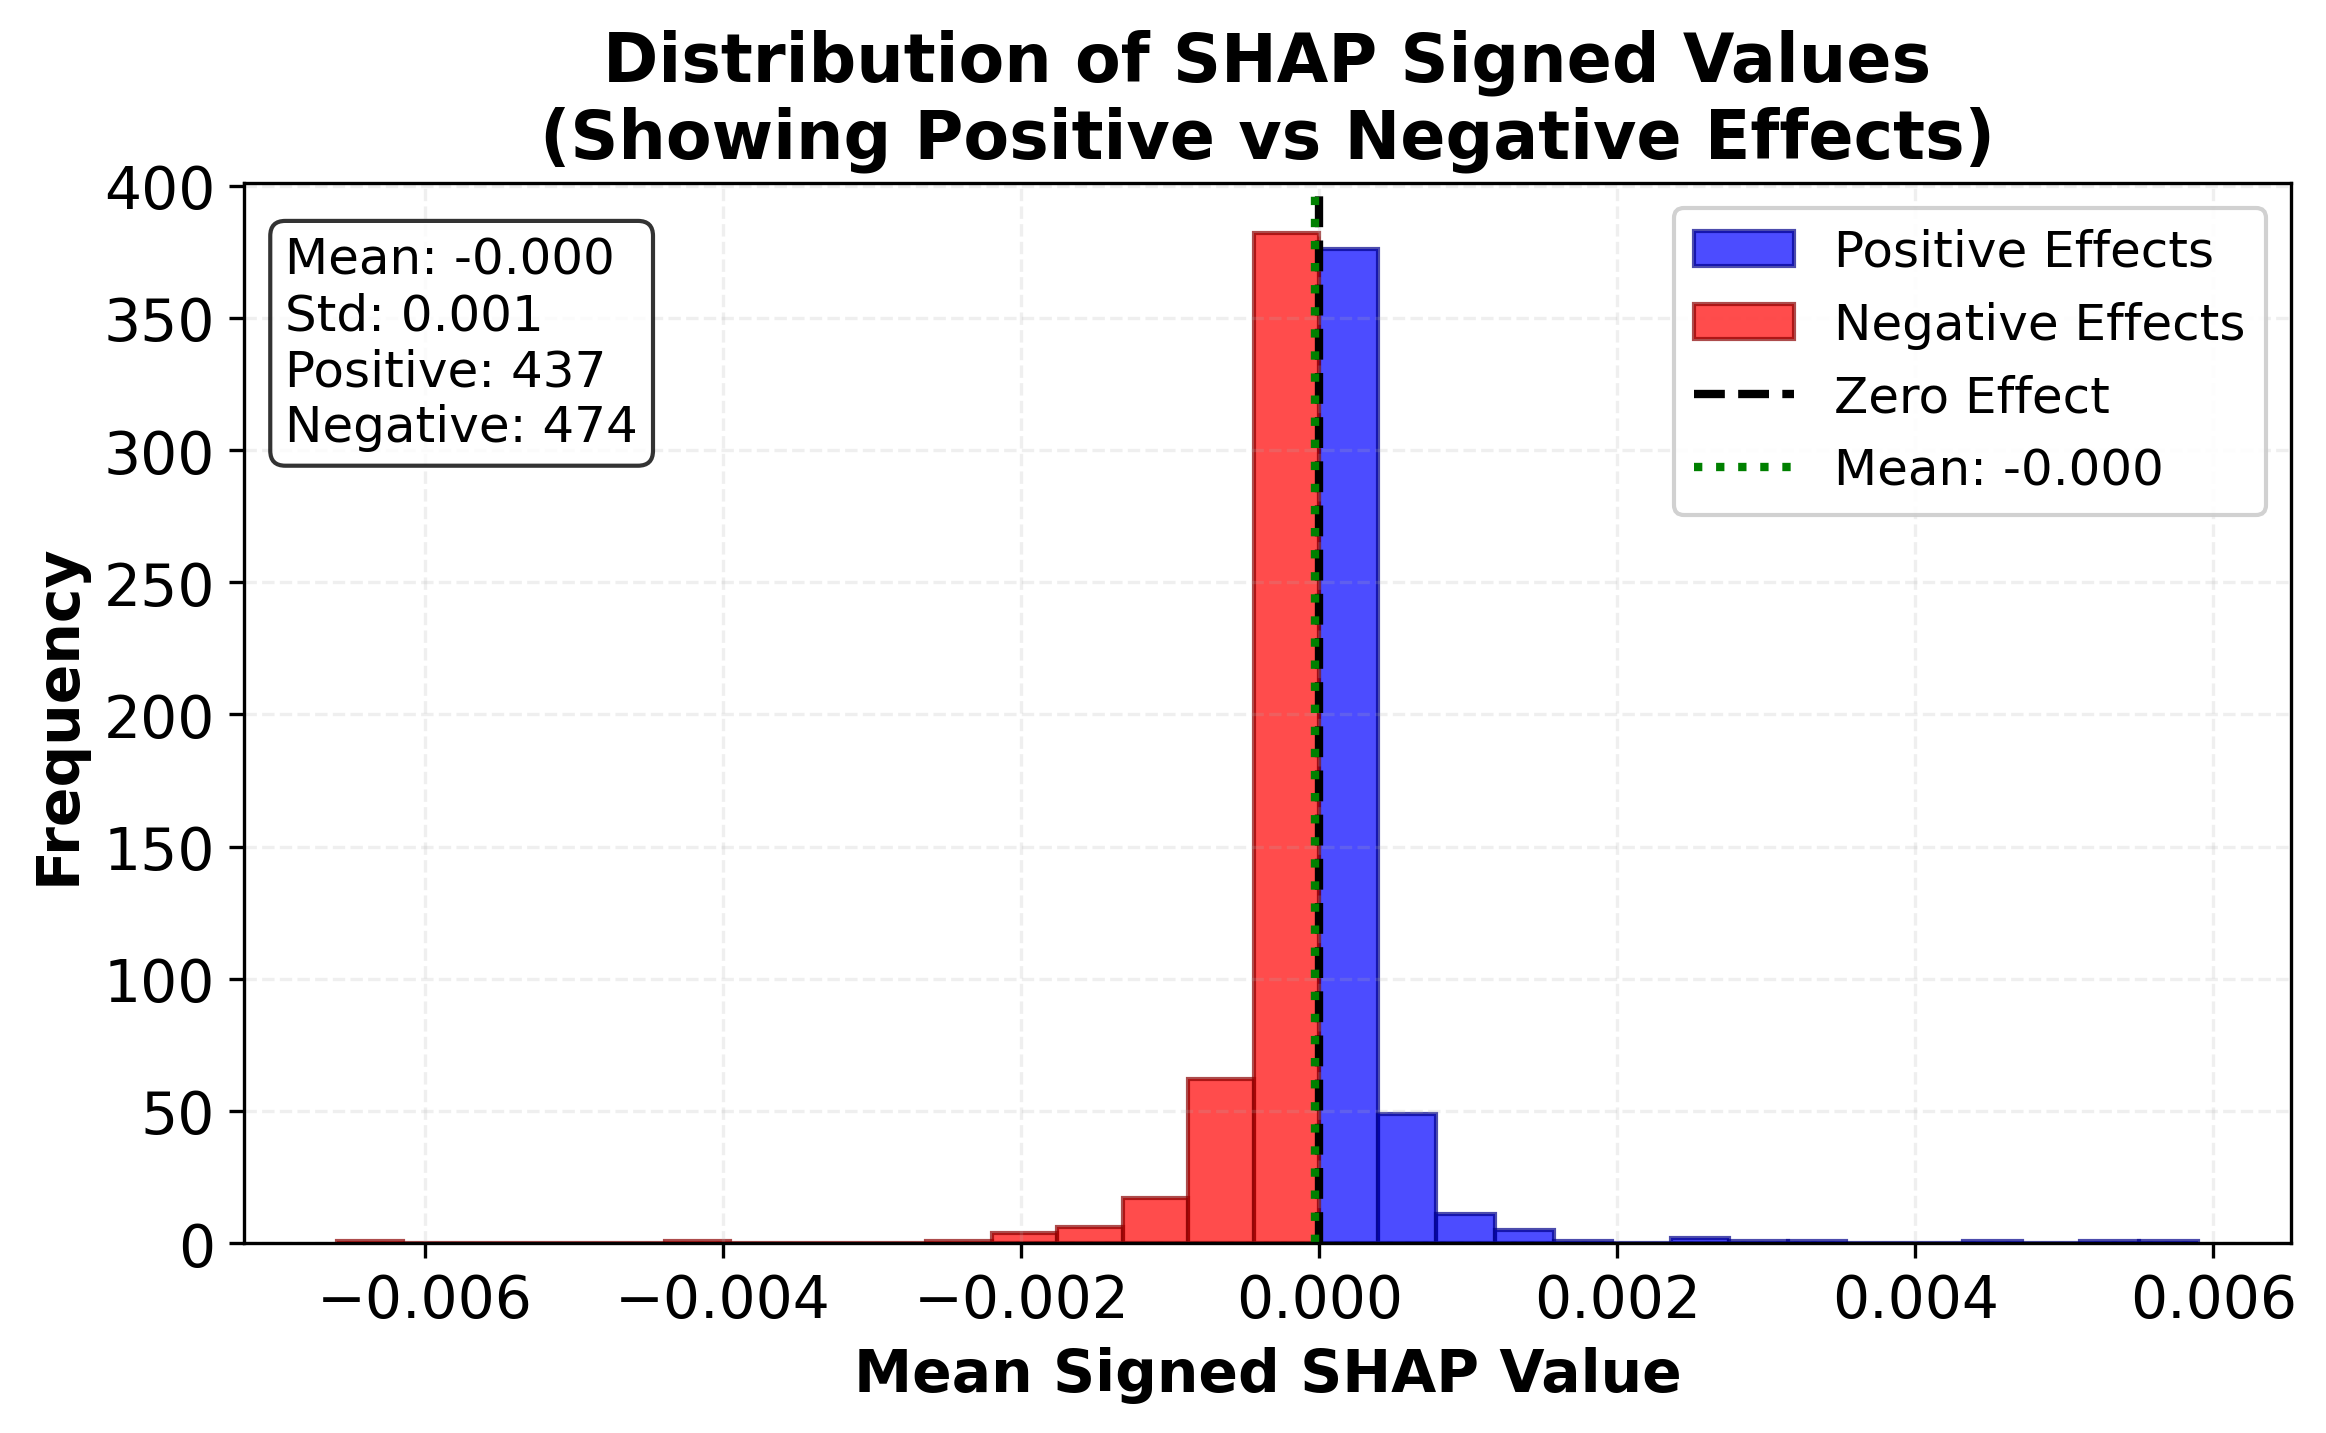

Created enhanced SHAP signed values distribution plot


In [15]:
if shap_signed_analysis is not None:
    signed_consensus = shap_signed_analysis['signed_consensus']
    
    # Data validation - check if we have both positive and negative values
    positive_count = len(signed_consensus[signed_consensus['mean_importance_signed'] > 0])
    negative_count = len(signed_consensus[signed_consensus['mean_importance_signed'] < 0])
    neutral_count = len(signed_consensus[signed_consensus['mean_importance_signed'] == 0])
    
    save_and_print(f"SHAP signed values distribution: {positive_count} positive, {negative_count} negative, {neutral_count} neutral", 
                   print_report_file, level="info")
    
    # Create publication-quality SHAP signed values visualization
    plt.rcParams['font.size'] = 14
    plt.rcParams['xtick.labelsize'] = 14  # Set x-tick size
    plt.rcParams['ytick.labelsize'] = 14  # Set y-tick size
    plt.figure(figsize=(10,6), dpi=300)
    
    # Create directional importance plot
    # Take top 20 features by ABSOLUTE importance (both positive and negative)
    # Calculate absolute importance for ranking
    signed_consensus_copy = signed_consensus.copy()
    signed_consensus_copy['abs_importance'] = signed_consensus_copy['mean_importance_signed'].abs()
    
    # Get top 20 features by absolute importance
    top_features = signed_consensus_copy.nlargest(20, 'abs_importance')
    
    # Sort by signed value for better visualization (negative to positive)
    top_features = top_features.sort_values('mean_importance_signed', ascending=True)
    
    # Create horizontal bar plot with color coding for direction
    colors = ['red' if x < 0 else 'blue' for x in top_features['mean_importance_signed']]
    
    # Create the bar plot
    bars = plt.barh(range(len(top_features)), top_features['mean_importance_signed'], 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=1)
    
    plt.yticks(range(len(top_features)), top_features.index, fontsize=12)
    plt.xlabel('Mean Signed SHAP Value', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title('Directional Feature Effects (Top 20 Features by Absolute Importance)', 
              fontsize=16, fontweight='bold')
    
    # Set x-axis limits to accommodate both positive and negative values
    x_min = top_features['mean_importance_signed'].min() * 1.1
    x_max = top_features['mean_importance_signed'].max() * 1.1
    plt.xlim(x_min, x_max)
    
    # Add value labels
    for i, (v, feature_name) in enumerate(zip(top_features['mean_importance_signed'], top_features.index)):
        # Position labels inside bars for better readability
        if v < 0:
            # For negative values, place label to the right of the bar
            plt.text(v + (x_max - x_min) * 0.01, i, f'{v:.3f}', va='center', fontsize=10, 
                    fontweight='bold', color='white' if abs(v) > 0.1 else 'black')
        else:
            # For positive values, place label to the left of the bar
            plt.text(v - (x_max - x_min) * 0.01, i, f'{v:.3f}', va='center', fontsize=10, 
                    fontweight='bold', color='white' if abs(v) > 0.1 else 'black', ha='right')
    
    # Add legend for direction
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=2)
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='Positive Effect (Promote Resistance)'),
        Patch(facecolor='red', alpha=0.7, label='Negative Effect (Promote Sensitivity)')
    ]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=12, framealpha=0.9)
    
    plt.grid(axis='x', alpha=0.2, linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}shap_signed_values_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created SHAP signed values visualization showing both positive and negative effects", 
                   print_report_file, level="info")
    
    # Create enhanced distribution plot of signed values
    plt.figure(figsize=(8,5), dpi=300)
    
    # Create histogram with better binning for signed values
    values = signed_consensus['mean_importance_signed']
    n_bins = min(30, len(values) // 5)  # Adaptive bin count
    
    # Use different colors for positive and negative regions
    plt.hist(values[values >= 0], bins=n_bins//2, alpha=0.7, color='blue', 
             edgecolor='darkblue', linewidth=1, label='Positive Effects')
    plt.hist(values[values < 0], bins=n_bins//2, alpha=0.7, color='red', 
             edgecolor='darkred', linewidth=1, label='Negative Effects')
    
    plt.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Effect')
    
    # Add statistical annotations
    mean_val = values.mean()
    std_val = values.std()
    plt.axvline(x=mean_val, color='green', linestyle=':', linewidth=2, 
                label=f'Mean: {mean_val:.3f}')
    
    plt.xlabel('Mean Signed SHAP Value', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    plt.title('Distribution of SHAP Signed Values\n(Showing Positive vs Negative Effects)', 
              fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, framealpha=0.9)
    plt.grid(alpha=0.2, linestyle='--')
    
    # Add statistical summary as text
    plt.text(0.02, 0.95, f'Mean: {mean_val:.3f}\nStd: {std_val:.3f}\n'
                         f'Positive: {positive_count}\nNegative: {negative_count}', 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.tight_layout()
    plt.savefig(f"{file_save_path}shap_signed_distribution_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created enhanced SHAP signed values distribution plot", print_report_file, level="info")

## SHAP Signed vs Importance Values Consistency Analysis

In [95]:
save_and_print("## SHAP Signed vs Importance Values Consistency Analysis", print_report_file, level="section")

def analyze_shap_consistency(data_files, file_save_path, exp_id):
    """
    Analyze consistency between SHAP importance values and signed values
    """
    shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
    
    if (shap_condition not in data_files or 
        'consensus_feature_importance' not in data_files[shap_condition] or
        'consensus_feature_importance_signed' not in data_files[shap_condition]):
        save_and_print("SHAP data not available for consistency analysis", print_report_file, level="info")
        return None
    
    # Get both importance and signed consensus data
    importance_consensus = data_files[shap_condition]['consensus_feature_importance']
    signed_consensus = data_files[shap_condition]['consensus_feature_importance_signed']
    
    # Create unified dataframe
    consistency_df = pd.DataFrame()
    
    # Get common features
    common_features = set(importance_consensus.index) & set(signed_consensus.index)
    
    for feature in common_features:
        importance_data = importance_consensus.loc[feature]
        signed_data = signed_consensus.loc[feature]
        
        consistency_df.loc[feature, 'importance_mean'] = importance_data.get('mean_importance', np.nan)
        consistency_df.loc[feature, 'importance_std'] = importance_data.get('std_importance', np.nan)
        consistency_df.loc[feature, 'signed_mean'] = signed_data.get('mean_importance_signed', np.nan)
        consistency_df.loc[feature, 'signed_std'] = signed_data.get('std_importance_signed', np.nan)
        consistency_df.loc[feature, 'occurrence_count'] = signed_data.get('occurrence_count', np.nan)
    
    # Calculate absolute signed values for comparison
    consistency_df['abs_signed_mean'] = consistency_df['signed_mean'].abs()
    
    # Calculate rankings
    consistency_df['importance_rank'] = consistency_df['importance_mean'].rank(ascending=False, method='min')
    consistency_df['signed_rank'] = consistency_df['abs_signed_mean'].rank(ascending=False, method='min')
    consistency_df['rank_difference'] = abs(consistency_df['importance_rank'] - consistency_df['signed_rank'])
    
    # Calculate correlation
    valid_data = consistency_df.dropna(subset=['importance_mean', 'abs_signed_mean'])
    if len(valid_data) > 1:
        pearson_corr, pearson_p = spearmanr(valid_data['importance_mean'], valid_data['abs_signed_mean'])
        spearman_corr, spearman_p = spearmanr(valid_data['importance_rank'], valid_data['signed_rank'])
    else:
        pearson_corr = pearson_p = spearman_corr = spearman_p = np.nan
    
    save_and_print("### SHAP Consistency Analysis Summary", print_report_file, level="subsection")
    save_and_print(f"Total features analyzed: {len(consistency_df)}", print_report_file, level="info")
    save_and_print(f"Pearson correlation (magnitude): {pearson_corr:.3f} (p={pearson_p:.4f})", print_report_file, level="info")
    save_and_print(f"Spearman correlation (ranking): {spearman_corr:.3f} (p={spearman_p:.4f})", print_report_file, level="info")
    
    # Identify consistency patterns
    top_n = min(20, len(consistency_df) // 4)
    top_importance = set(consistency_df.nsmallest(top_n, 'importance_rank').index)
    top_signed = set(consistency_df.nsmallest(top_n, 'signed_rank').index)
    overlap = len(top_importance & top_signed)
    
    save_and_print(f"Top {top_n} features overlap: {overlap}/{top_n} ({overlap/top_n*100:.1f}%)", print_report_file, level="info")
    
    return consistency_df, pearson_corr, spearman_corr

# Perform consistency analysis
shap_consistency_results = analyze_shap_consistency(data_files, file_save_path, exp_id)

## SHAP Signed vs Importance Values Consistency Analysis
### SHAP Consistency Analysis Summary
Total features analyzed: 923
Pearson correlation (magnitude): 0.677 (p=0.0000)
Spearman correlation (ranking): 0.677 (p=0.0000)
Top 20 features overlap: 10/20 (50.0%)


### SHAP Consistency Scatter Plot

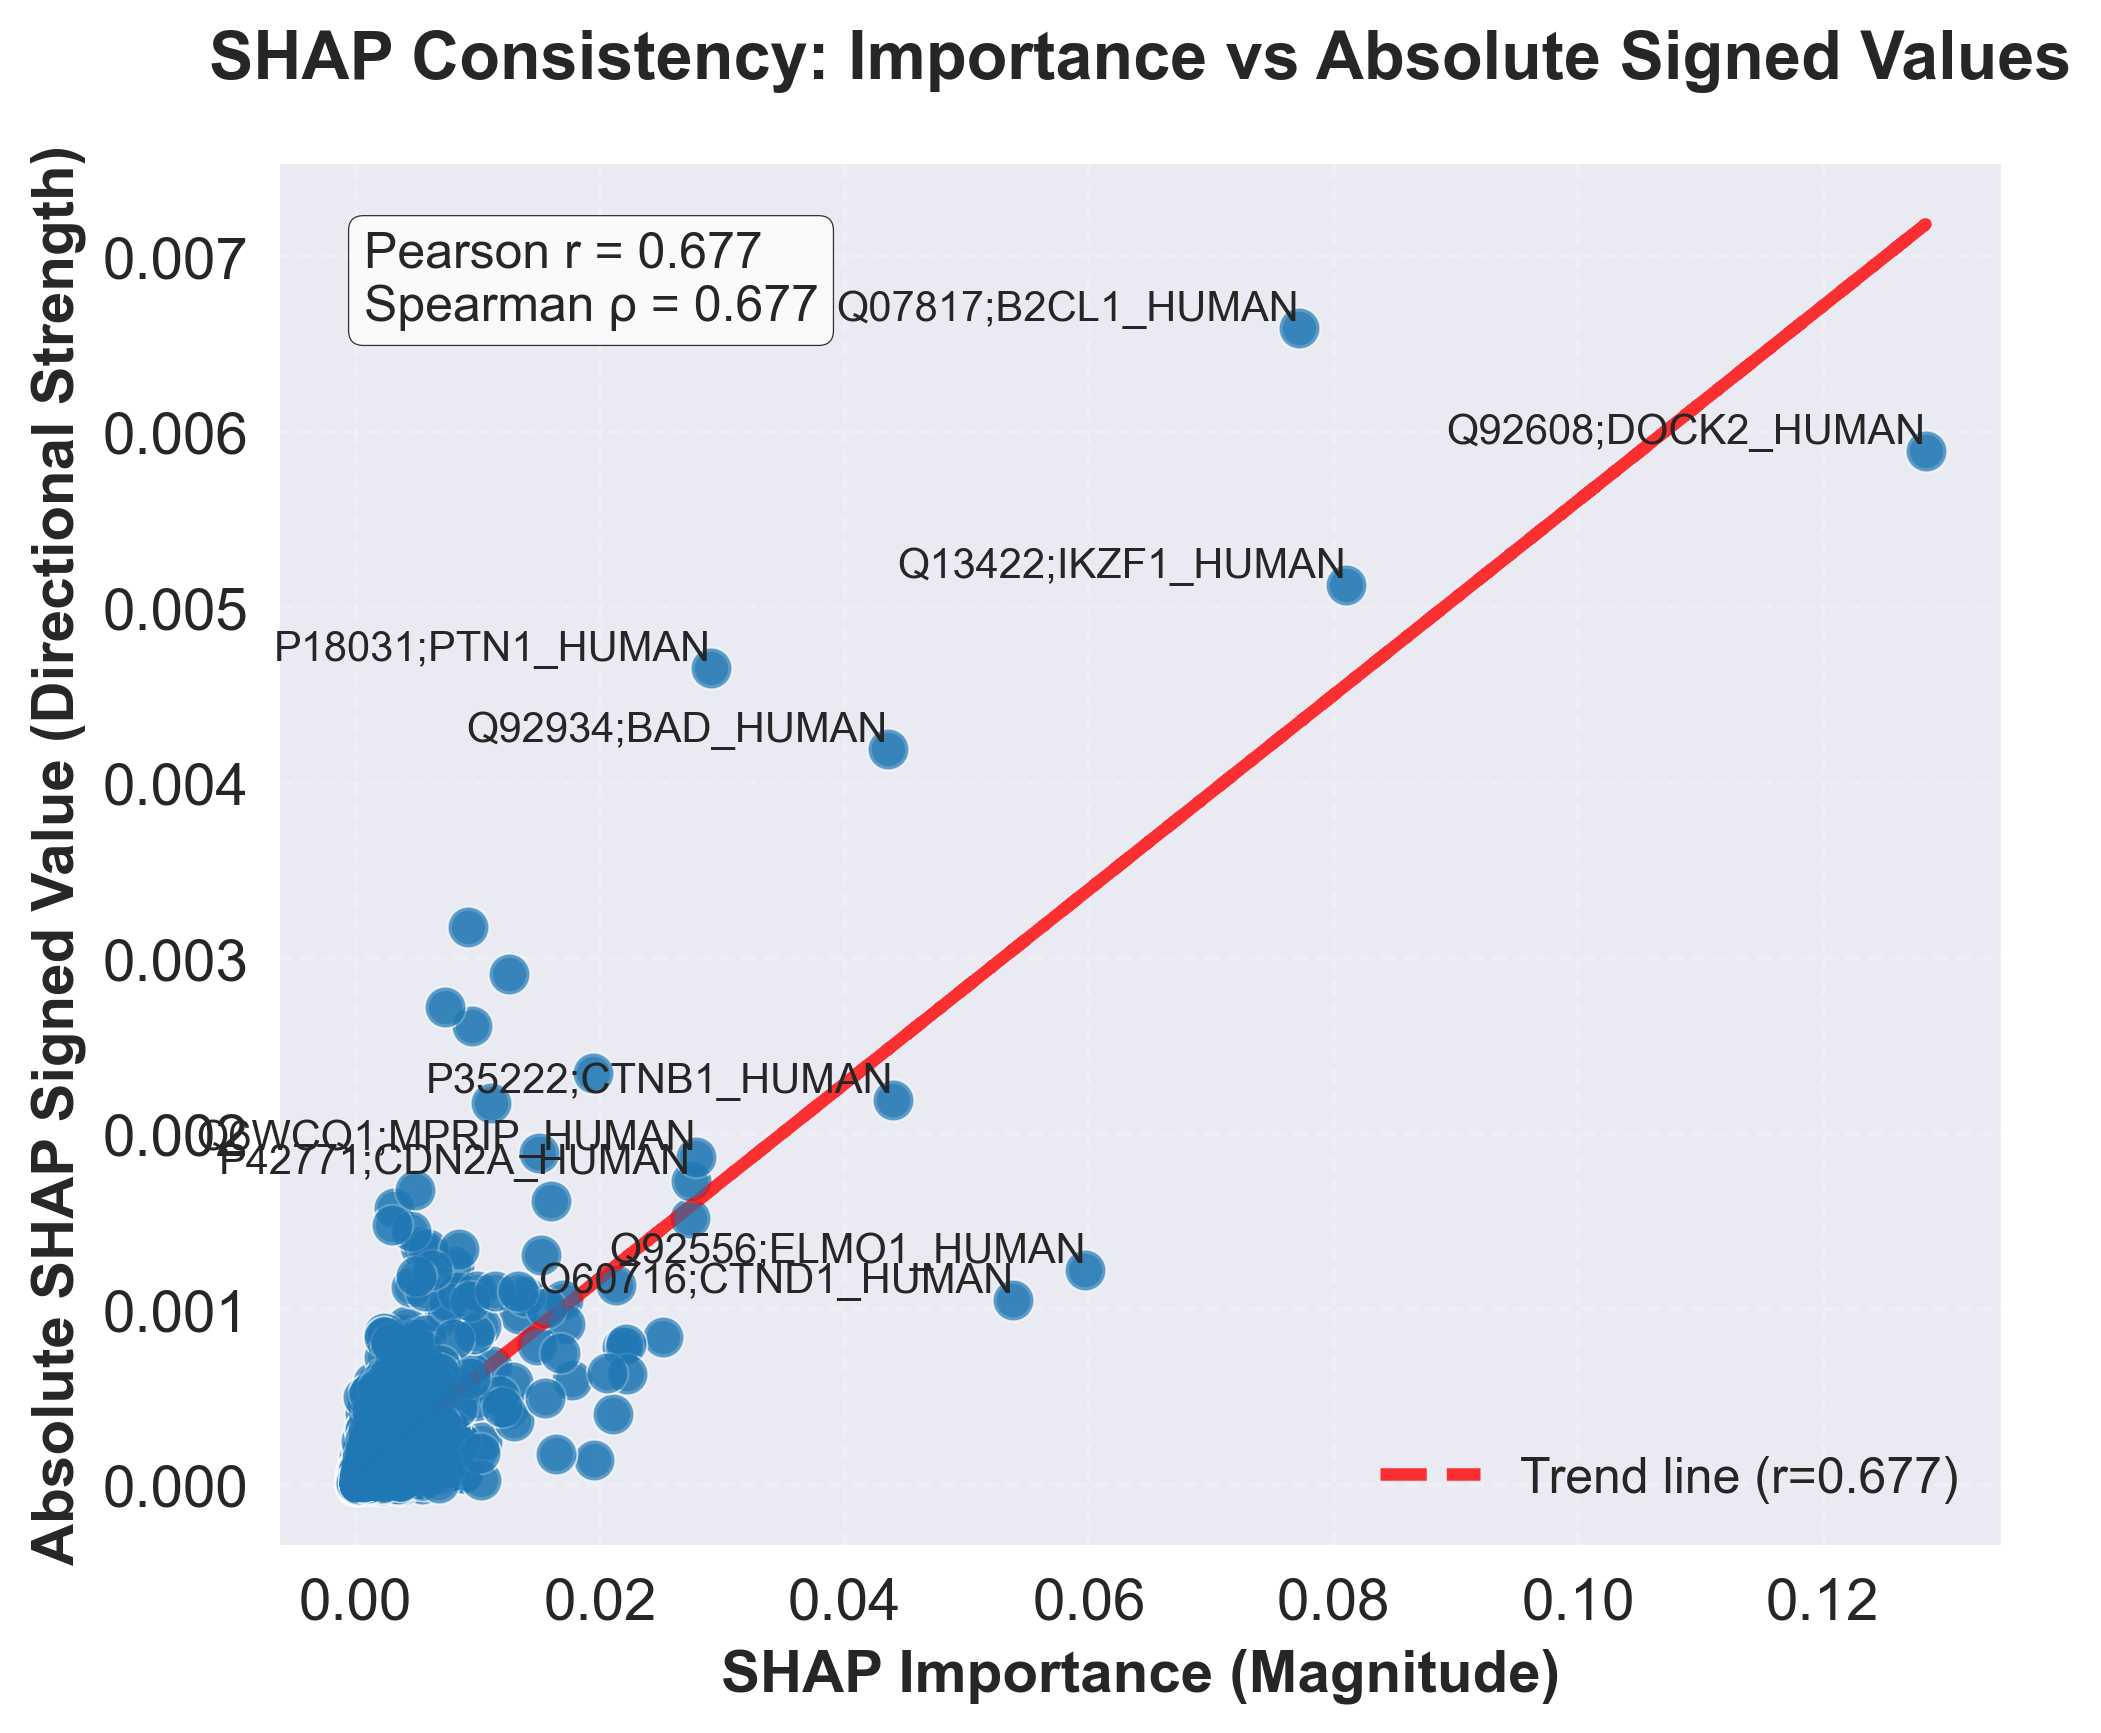

Created SHAP consistency scatter plot
### Top 10 Most Inconsistent Features
                    importance_mean  abs_signed_mean  importance_rank  signed_rank  rank_difference
P35269;T2FA_HUMAN          0.005446         0.000004            121.0        872.0            751.0
P18858;DNLI1_HUMAN         0.006789         0.000011             82.0        830.0            748.0
P50750;CDK9_HUMAN          0.010252         0.000025             45.0        761.0            716.0
Q13813;SPTN1_HUMAN         0.003702         0.000000            237.0        912.0            675.0
Q3B726;RPA43_HUMAN         0.005560         0.000024            116.0        765.0            649.0
Q99549;MPP8_HUMAN          0.003472         0.000001            274.0        901.0            627.0
Q9UJX5;APC4_HUMAN          0.000589         0.000497            746.0        134.0            612.0
P16401;H15_HUMAN           0.005429         0.000031            122.0        730.0            608.0
P07948;LYN_HUMAN        

In [96]:
if shap_consistency_results is not None:
    consistency_df, pearson_corr, spearman_corr = shap_consistency_results
    
    # Create publication-quality scatter plot
    plt.rcParams['font.size'] = 14
    plt.figure(figsize=(7, 6), dpi=300)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    # Scatter plot without error bars: draw points and annotate top features.
    plt.scatter(consistency_df['importance_mean'], consistency_df['abs_signed_mean'],
                c='#1f77b4', alpha=0.7, s=100, edgecolors='w', linewidth=0.5)
    
    # Suppress error bars by zeroing std columns so the subsequent plt.errorbar call produces no visible bars
    if 'importance_std' in consistency_df.columns:
        consistency_df['importance_std'] = 0.0
    if 'signed_std' in consistency_df.columns:
        consistency_df['signed_std'] = 0.0
    
    # Annotate top 10 features by importance for readability
    top10 = consistency_df['importance_mean'].nlargest(10).index
    for feat in top10:
        x = consistency_df.loc[feat, 'importance_mean']
        y = consistency_df.loc[feat, 'abs_signed_mean']
        plt.text(x, y, feat, fontsize=10, va='bottom', ha='right', rotation=0)
    plt.errorbar(consistency_df['importance_mean'], consistency_df['abs_signed_mean'],
                 xerr=consistency_df['importance_std'], yerr=consistency_df['signed_std'],
                 fmt='o', alpha=0.6, markersize=8, capsize=3, 
                 color='#1f77b4', ecolor='#1f77b4', elinewidth=1)
    
    # Add trend line if correlation is significant
    if pearson_corr > 0.3 and len(consistency_df) > 2:
        z = np.polyfit(consistency_df['importance_mean'], consistency_df['abs_signed_mean'], 1)
        p = np.poly1d(z)
        plt.plot(consistency_df['importance_mean'], p(consistency_df['importance_mean']), 
                 "r--", alpha=0.8, linewidth=3, label=f'Trend line (r={pearson_corr:.3f})')
        plt.legend(fontsize=12)
    
    plt.xlabel('SHAP Importance (Magnitude)', fontsize=14, fontweight='bold')
    plt.ylabel('Absolute SHAP Signed Value (Directional Strength)', fontsize=14, fontweight='bold')
    plt.title('SHAP Consistency: Importance vs Absolute Signed Values', 
              fontsize=16, fontweight='bold', pad=20)
    
    # Add correlation annotation
    plt.text(0.05, 0.95, f'Pearson r = {pearson_corr:.3f}\nSpearman ρ = {spearman_corr:.3f}', 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             verticalalignment='top')
    
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}shap_consistency_scatter_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created SHAP consistency scatter plot", print_report_file, level="info")
    
    # Print top inconsistent features
    save_and_print("### Top 10 Most Inconsistent Features", print_report_file, level="subsection")
    inconsistent_features = consistency_df.nlargest(10, 'rank_difference')[['importance_mean', 'abs_signed_mean', 'importance_rank', 'signed_rank', 'rank_difference']]
    save_and_print(inconsistent_features.to_string(), print_report_file, level="info")

## MDI Feature Importance Visualization

## MDI Feature Importance Visualization


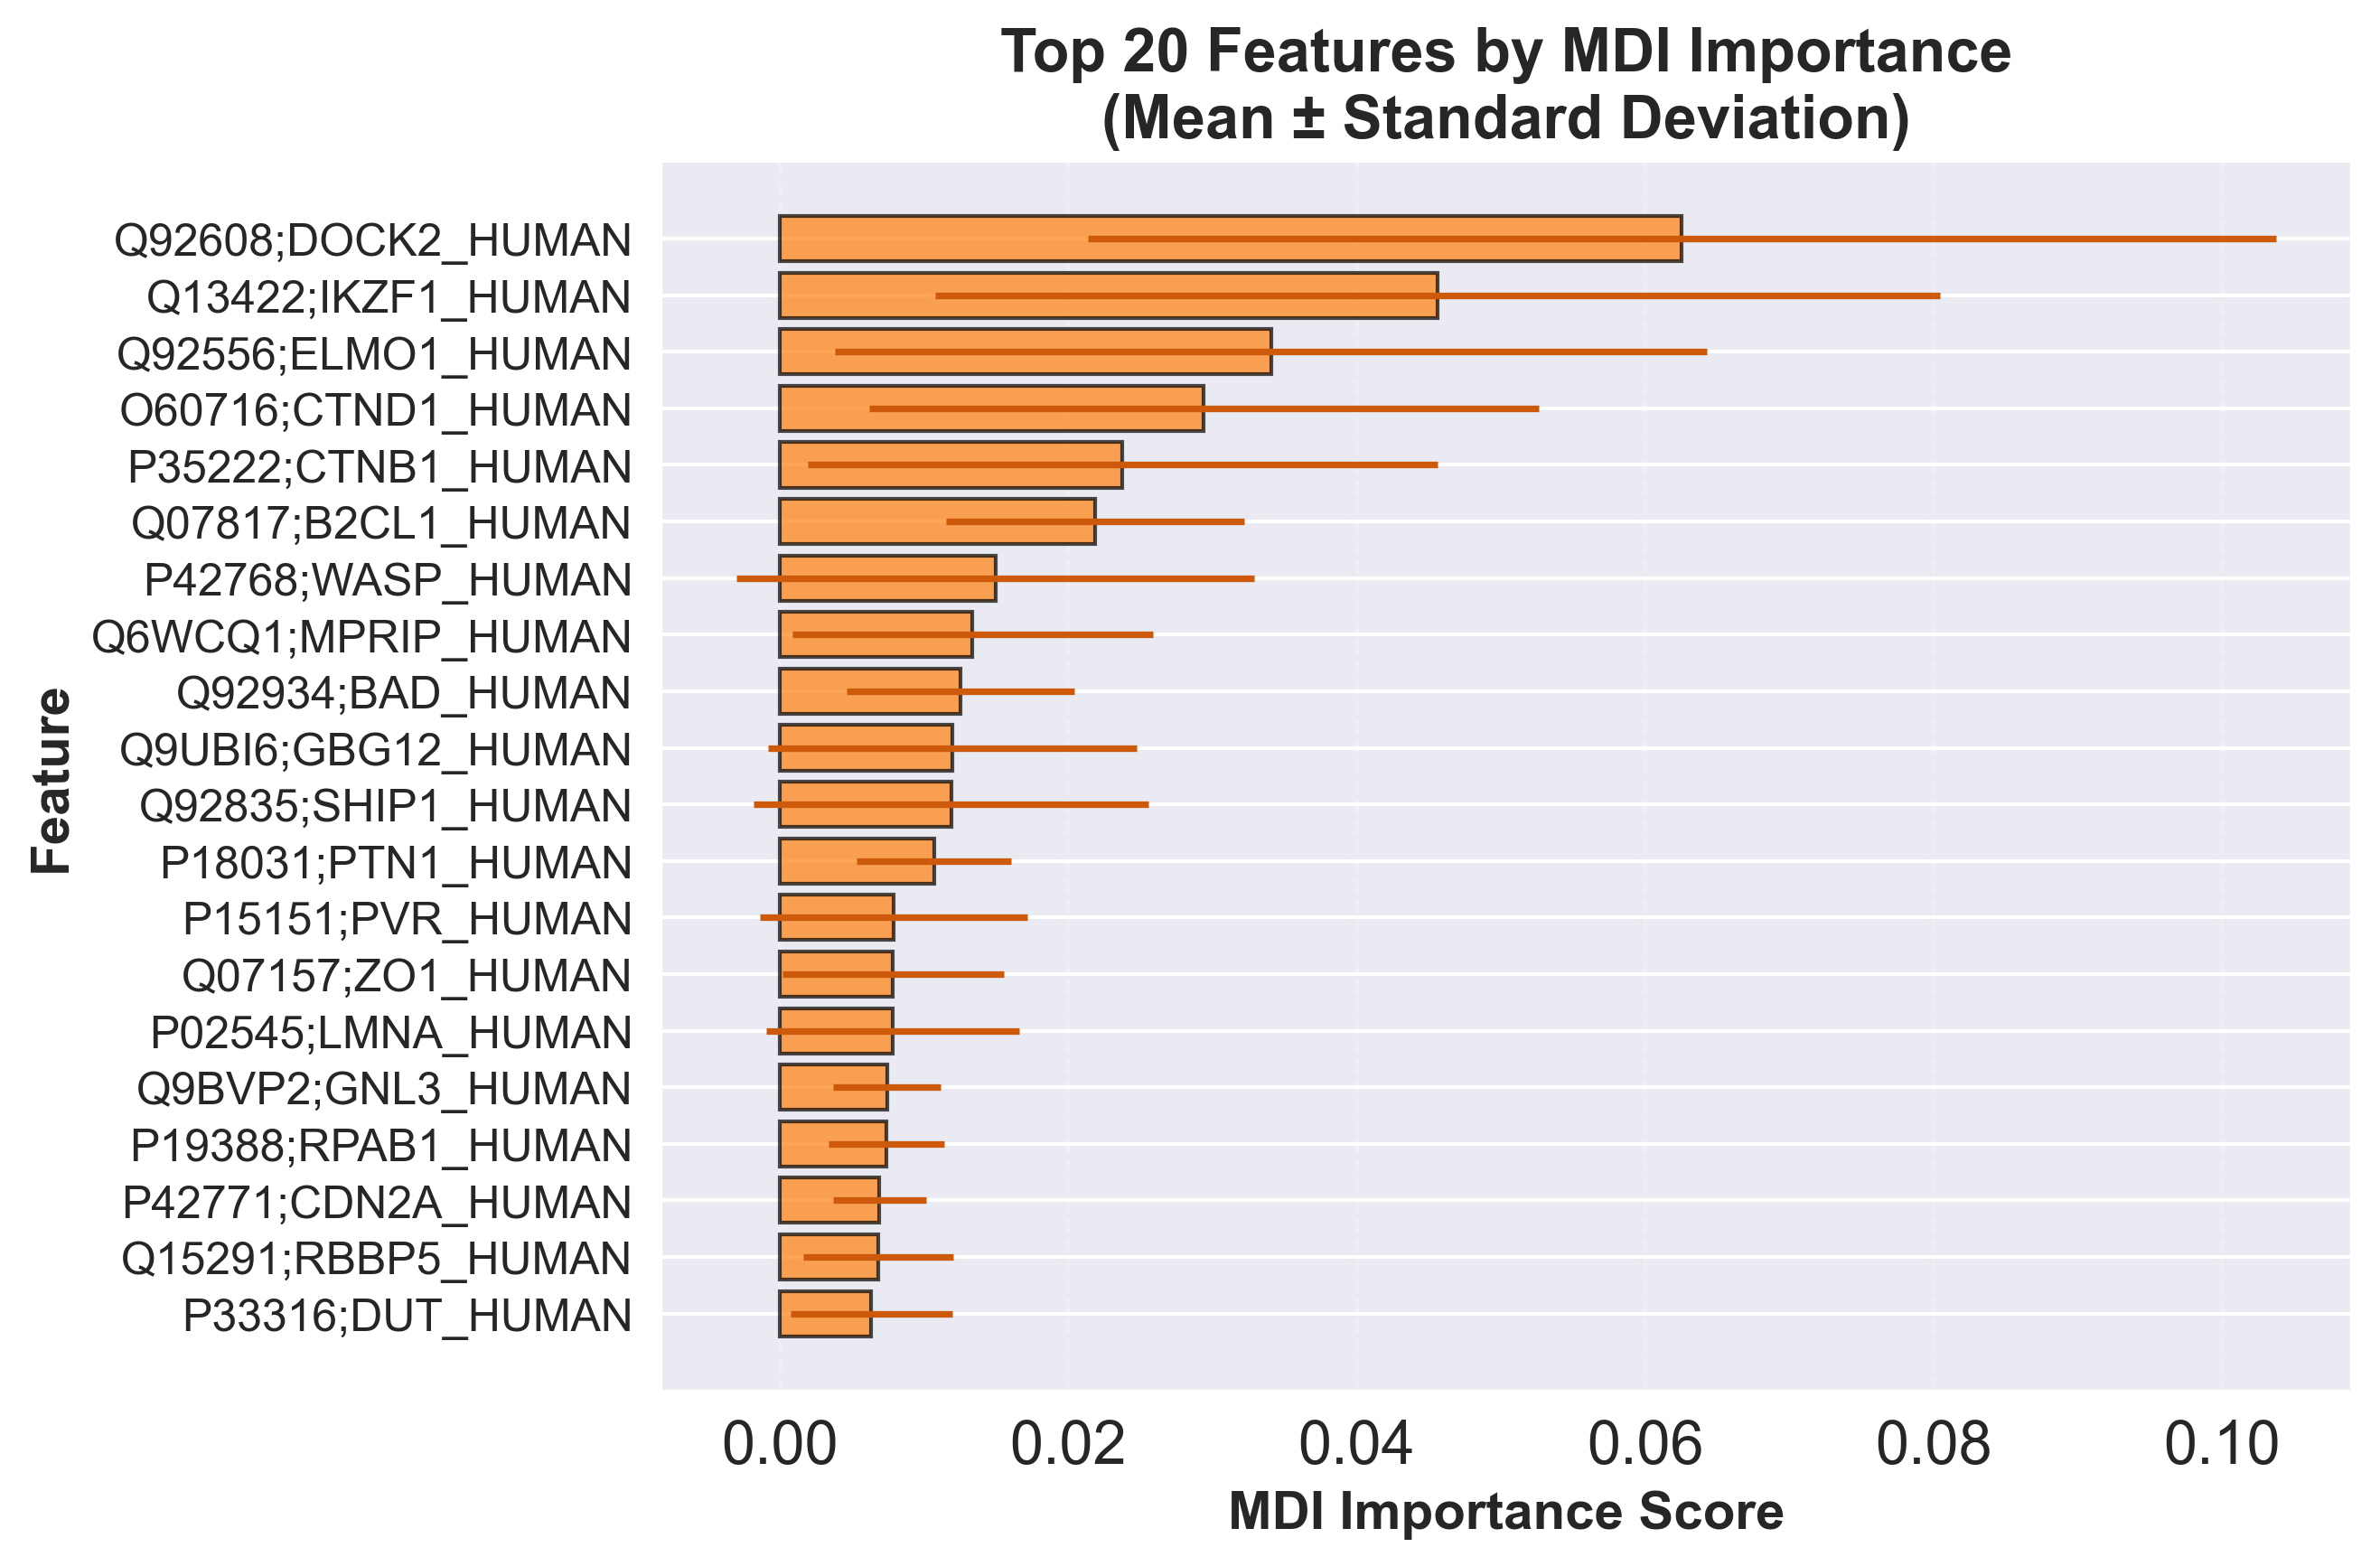

Created MDI consensus feature importance bar plot


In [97]:
save_and_print("## MDI Feature Importance Visualization", print_report_file, level="section")

def visualize_mdi_importance(data_files, file_save_path, exp_id):
    """
    Create MDI consensus feature importance visualization
    """
    mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
    
    if mdi_condition not in data_files or 'consensus_feature_importance' not in data_files[mdi_condition]:
        save_and_print("MDI consensus data not available for visualization", print_report_file, level="info")
        return None
    
    mdi_consensus = data_files[mdi_condition]['consensus_feature_importance']
    
    # Get top 20 features by MDI importance and sort in descending order
    top_mdi_features = mdi_consensus.nlargest(20, 'mean_importance')
    
    # Reverse the order so most important features are at the top
    top_mdi_features = top_mdi_features.sort_values('mean_importance', ascending=True)
    
    # Create publication-quality MDI bar plot
    plt.figure(figsize=(9, 6), dpi=300)
    plt.rcParams['font.size'] = 14
    
    # Create horizontal bar plot with proper ordering
    y_pos = range(len(top_mdi_features))
    bars = plt.barh(y_pos, top_mdi_features['mean_importance'], 
                    xerr=top_mdi_features['std_importance'], 
                    color='#ff7f0e', alpha=0.7, edgecolor='black', linewidth=1,
                    capsize=5, ecolor='#cc5a0a')
    
    plt.yticks(y_pos, top_mdi_features.index, fontsize=12)
    plt.xticks(fontsize=16)
    plt.xlabel('MDI Importance Score', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title('Top 20 Features by MDI Importance\n(Mean ± Standard Deviation)', 
              fontsize=16, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.2, linestyle='--')
    plt.tight_layout()
    plt.savefig(f"{file_save_path}mdi_consensus_importance_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    save_and_print("Created MDI consensus feature importance bar plot", print_report_file, level="info")
    
    return top_mdi_features

# Perform MDI visualization
mdi_top_features = visualize_mdi_importance(data_files, file_save_path, exp_id)

### MDI vs SHAP Comparison

### MDI vs SHAP Feature Importance Comparison


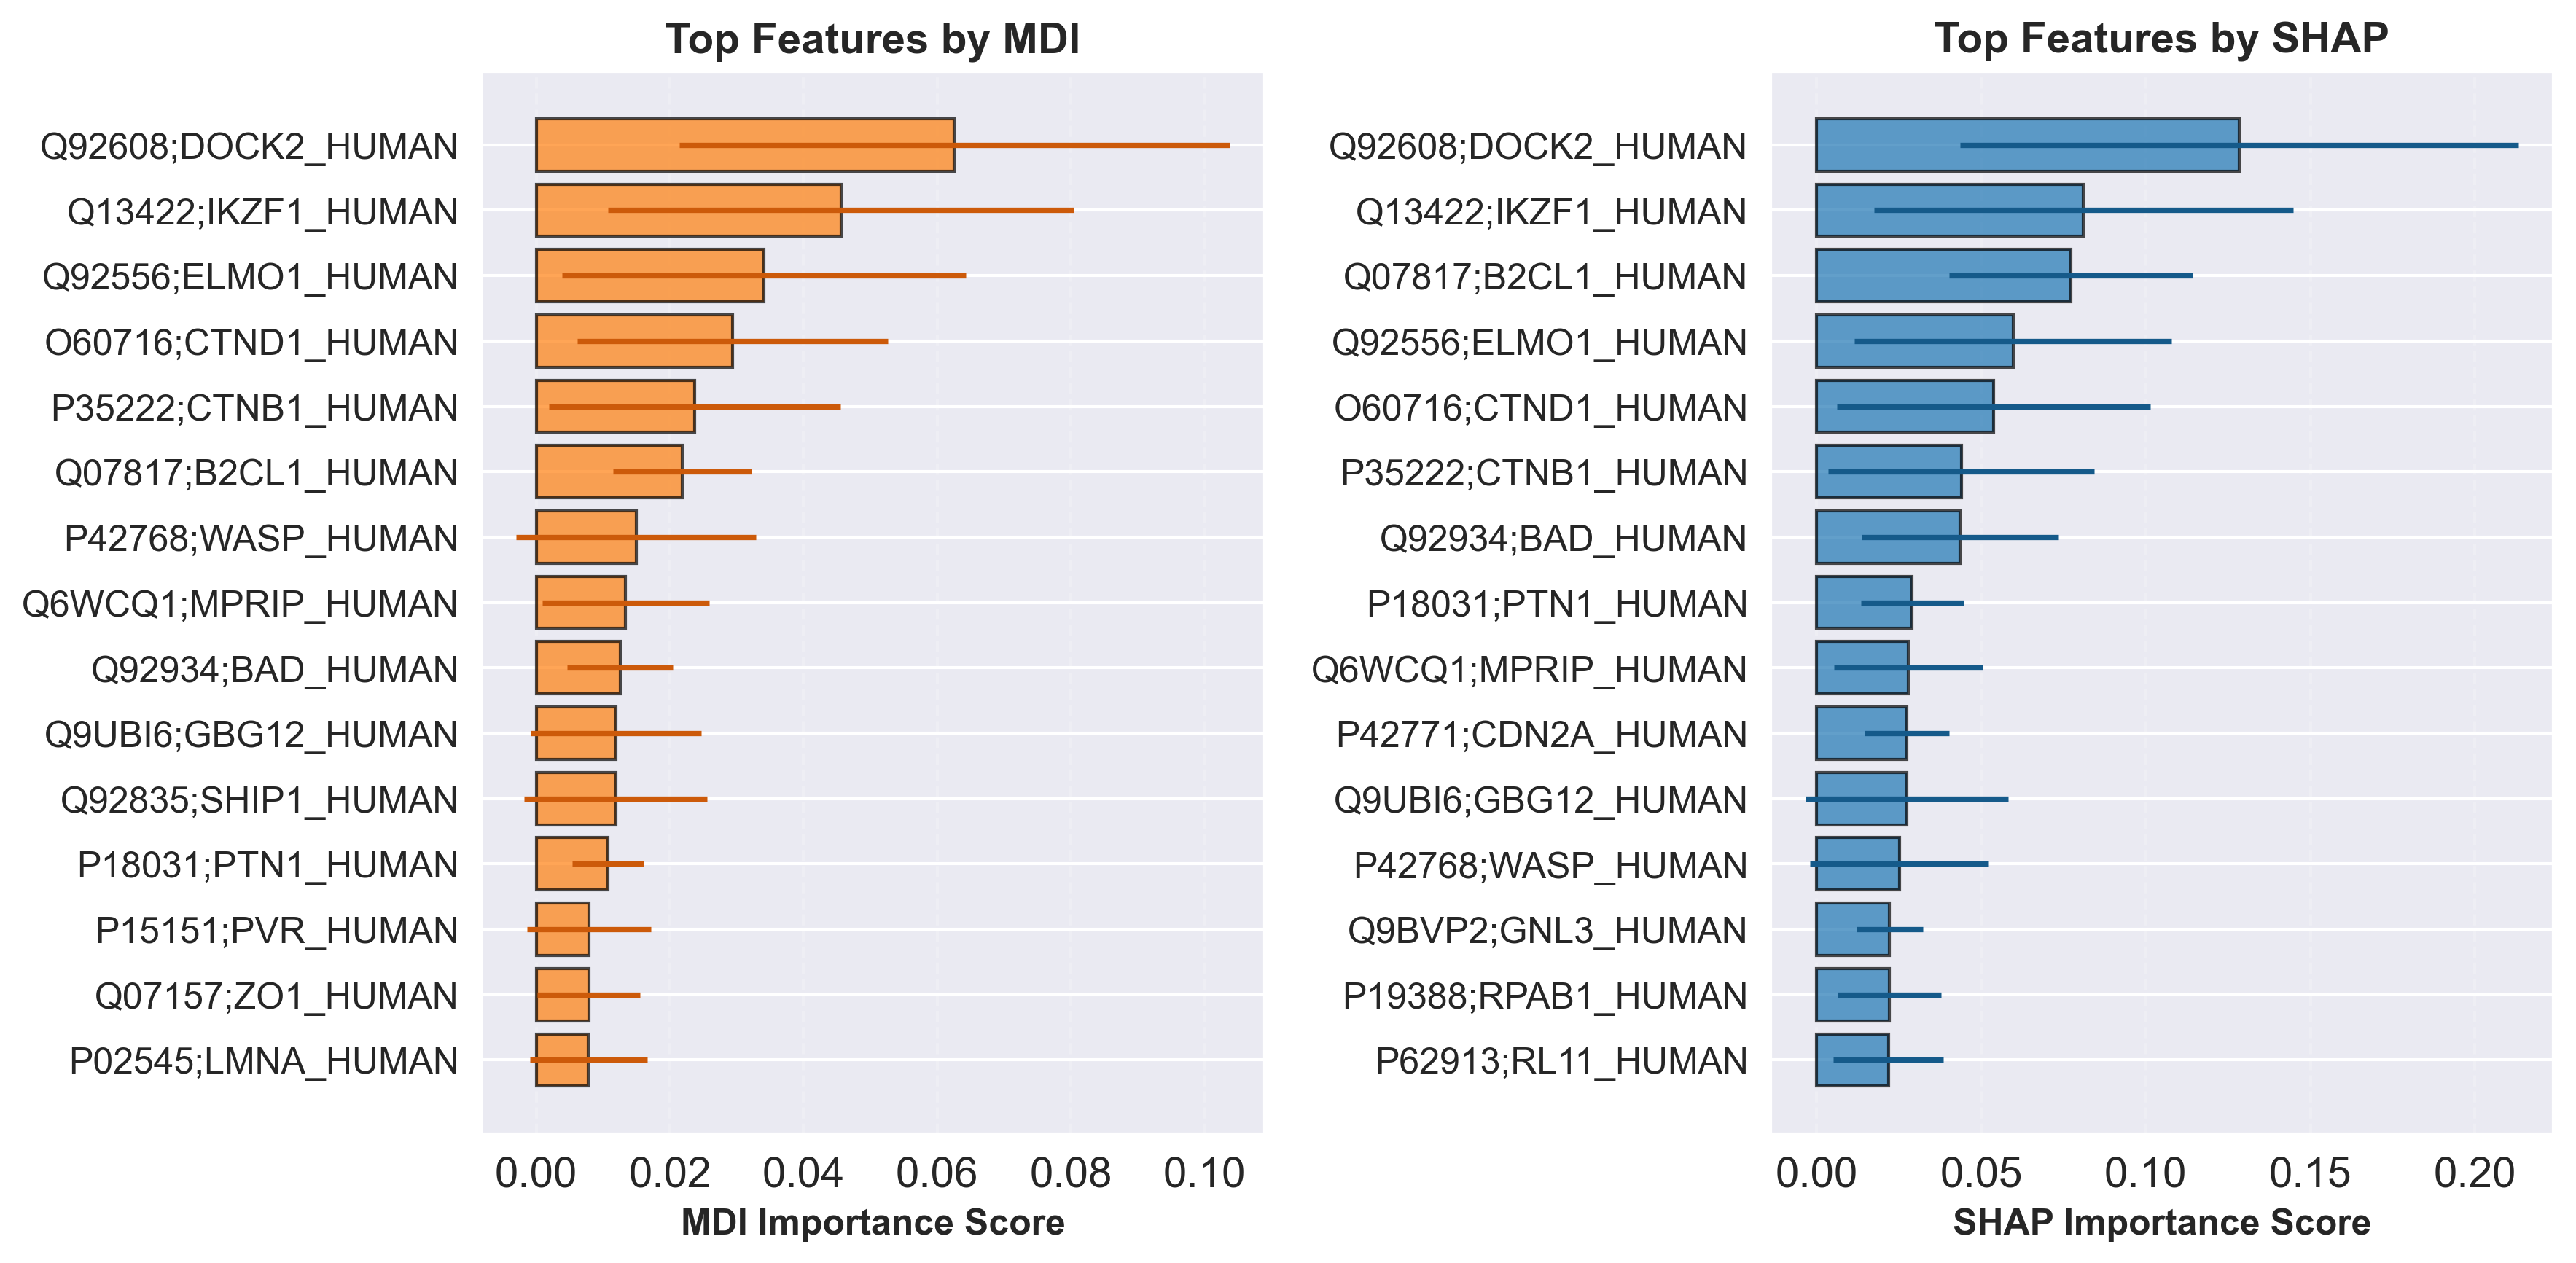

**Top 15 Features Overlap Analysis:**
- MDI unique features: 4
- SHAP unique features: 4
- Overlapping features: 11
- Overlap percentage: 73.3%
**Overlapping features:**
  - O60716;CTND1_HUMAN: MDI rank #4, SHAP rank #5
  - P18031;PTN1_HUMAN: MDI rank #12, SHAP rank #8
  - P35222;CTNB1_HUMAN: MDI rank #5, SHAP rank #6
  - P42768;WASP_HUMAN: MDI rank #7, SHAP rank #12
  - Q07817;B2CL1_HUMAN: MDI rank #6, SHAP rank #3
  - Q13422;IKZF1_HUMAN: MDI rank #2, SHAP rank #2
  - Q6WCQ1;MPRIP_HUMAN: MDI rank #8, SHAP rank #9
  - Q92556;ELMO1_HUMAN: MDI rank #3, SHAP rank #4
  - Q92608;DOCK2_HUMAN: MDI rank #1, SHAP rank #1
  - Q92934;BAD_HUMAN: MDI rank #9, SHAP rank #7
  - Q9UBI6;GBG12_HUMAN: MDI rank #10, SHAP rank #11


In [98]:
save_and_print("### MDI vs SHAP Feature Importance Comparison", print_report_file, level="subsection")

def compare_mdi_shap(data_files, file_save_path, exp_id, top_n=15):
    """
    Compare MDI and SHAP feature importance rankings
    """
    mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
    shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
    
    if (mdi_condition not in data_files or 'consensus_feature_importance' not in data_files[mdi_condition] or
        shap_condition not in data_files or 'consensus_feature_importance' not in data_files[shap_condition]):
        save_and_print("MDI or SHAP consensus data not available for comparison", print_report_file, level="info")
        return None
    
    mdi_consensus = data_files[mdi_condition]['consensus_feature_importance']
    shap_consensus = data_files[shap_condition]['consensus_feature_importance']
    
    # Get top features from both methods and sort in descending order
    top_mdi = mdi_consensus.nlargest(top_n, 'mean_importance')
    top_shap = shap_consensus.nlargest(top_n, 'mean_importance')
    
    # Reverse the order so most important features are at the top
    top_mdi = top_mdi.sort_values('mean_importance', ascending=True)
    top_shap = top_shap.sort_values('mean_importance', ascending=True)
    
    # Create side-by-side comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
    plt.rcParams['font.size'] = 14
    
    # MDI plot
    y_pos = range(len(top_mdi))
    ax1.barh(y_pos, top_mdi['mean_importance'], 
             xerr=top_mdi['std_importance'], 
             color='#ff7f0e', alpha=0.7, edgecolor='black', linewidth=1,
             capsize=5, ecolor='#cc5a0a')
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_mdi.index, fontsize=12)
    ax1.set_xlabel('MDI Importance Score', fontsize=12, fontweight='bold')
    ax1.set_title('Top Features by MDI', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.2, linestyle='--')
    
    # SHAP plot
    y_pos = range(len(top_shap))
    ax2.barh(y_pos, top_shap['mean_importance'], 
             xerr=top_shap['std_importance'], 
             color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=1,
             capsize=5, ecolor='#155a8a')
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_shap.index, fontsize=12)
    ax2.set_xlabel('SHAP Importance Score', fontsize=12, fontweight='bold')
    ax2.set_title('Top Features by SHAP', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.2, linestyle='--')

    # Set tick sizes for both axes
    ax1.tick_params(axis="x", labelsize=14)  # X-axis ticks for MDI
    ax1.tick_params(axis="y", labelsize=12)  # Y-axis ticks for MDI
    ax2.tick_params(axis="x", labelsize=14)  # X-axis ticks for SHAP
    ax2.tick_params(axis="y", labelsize=12)  # Y-axis ticks for SHAP

    plt.tight_layout()
    plt.savefig(f"{file_save_path}mdi_shap_comparison_{exp_id}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate overlap and correlation
    mdi_features = set(mdi_consensus.nlargest(top_n, 'mean_importance').index)  # Use original order for ranking
    shap_features = set(shap_consensus.nlargest(top_n, 'mean_importance').index)  # Use original order for ranking
    overlap = mdi_features.intersection(shap_features)
    
    save_and_print(f"**Top {top_n} Features Overlap Analysis:**", print_report_file, level="info")
    save_and_print(f"- MDI unique features: {len(mdi_features - shap_features)}", print_report_file, level="info")
    save_and_print(f"- SHAP unique features: {len(shap_features - mdi_features)}", print_report_file, level="info")
    save_and_print(f"- Overlapping features: {len(overlap)}", print_report_file, level="info")
    save_and_print(f"- Overlap percentage: {len(overlap) / top_n * 100:.1f}%", print_report_file, level="info")
    
    if overlap:
        save_and_print("**Overlapping features:**", print_report_file, level="info")
        for feature in sorted(overlap):
            mdi_rank = list(mdi_consensus.nlargest(top_n, 'mean_importance').index).index(feature) + 1
            shap_rank = list(shap_consensus.nlargest(top_n, 'mean_importance').index).index(feature) + 1
            save_and_print(f"  - {feature}: MDI rank #{mdi_rank}, SHAP rank #{shap_rank}", print_report_file, level="info")
    
    return top_mdi, top_shap

# Perform comparison
comparison_results = compare_mdi_shap(data_files, file_save_path, exp_id)

### Shared Feature Selection Method

In [99]:
def get_selected_features(mdi_consensus, shap_consensus, min_occurrence_threshold=0.5, k_value=500):
    """
    Get selected features from MDI and SHAP consensus data using consistent threshold logic
    
    Args:
        mdi_consensus: MDI consensus feature importance data
        shap_consensus: SHAP consensus feature importance data
        min_occurrence_threshold: Minimum occurrence ratio threshold (default: 0.5 = 50%)
        k_value: Total number of iterations (default: 500)
    
    Returns:
        Dictionary containing selected feature sets and counts
    """
    mdi_selected_features = set()
    shap_selected_features = set()
    
    # For MDI: consider features with occurrence count above threshold
    for feature, data in mdi_consensus.items():
        if 'occurrence_count' in data and data['occurrence_count'] >= min_occurrence_threshold * k_value:
            mdi_selected_features.add(feature)
    
    # For SHAP: consider features with occurrence count above threshold
    for feature, data in shap_consensus.items():
        if 'occurrence_count' in data and data['occurrence_count'] >= min_occurrence_threshold * k_value:
            shap_selected_features.add(feature)
    
    # If occurrence_count is not available, use importance score threshold (fallback)
    if not mdi_selected_features:
        importance_threshold = mdi_consensus['mean_importance'].quantile(0.5)
        mdi_selected_features = set(mdi_consensus[mdi_consensus['mean_importance'] >= importance_threshold].index)
    
    if not shap_selected_features:
        importance_threshold = shap_consensus['mean_importance'].quantile(0.5)
        shap_selected_features = set(shap_consensus[shap_consensus['mean_importance'] >= importance_threshold].index)
    
    # Calculate union and intersection
    total_selected_features = mdi_selected_features.union(shap_selected_features)
    total_overlap = mdi_selected_features.intersection(shap_selected_features)
    
    return {
        'mdi_selected': mdi_selected_features,
        'shap_selected': shap_selected_features,
        'total_selected': total_selected_features,
        'overlap': total_overlap,
        'threshold': min_occurrence_threshold,
        'k_value': k_value
    }

### Total Overlap Analysis for All Selected Features

In [100]:
save_and_print("### Total Overlap Analysis for All Selected Features", print_report_file, level="subsection")

def calculate_mdi_shap_total_overlap(data_files, min_occurrence_threshold=0.5):
    """
    Calculate comprehensive overlap statistics between MDI and SHAP feature selections
    including total overlap percentage for all selected features, not just top N
    
    Args:
        data_files: Dictionary containing the data files
        min_occurrence_threshold: Minimum occurrence count threshold to consider a feature as "selected"
    
    Returns:
        Dictionary containing comprehensive overlap statistics
    """
    mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
    shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
    
    if (mdi_condition not in data_files or 'consensus_feature_importance' not in data_files[mdi_condition] or
        shap_condition not in data_files or 'consensus_feature_importance' not in data_files[shap_condition]):
        save_and_print("MDI or SHAP consensus data not available for total overlap analysis", print_report_file, level="info")
        return None
    
    mdi_consensus = data_files[mdi_condition]['consensus_feature_importance']
    shap_consensus = data_files[shap_condition]['consensus_feature_importance']
    
    # Use the shared feature selection method
    selected_features = get_selected_features(mdi_consensus, shap_consensus, min_occurrence_threshold, k_value)
    
    # Calculate top 15 overlap (existing functionality)
    top_n = 15
    top_mdi_features = set(mdi_consensus.nlargest(top_n, 'mean_importance').index)
    top_shap_features = set(shap_consensus.nlargest(top_n, 'mean_importance').index)
    top_overlap = top_mdi_features.intersection(top_shap_features)
    
    # Extract selected features from the shared method
    mdi_selected_features = selected_features['mdi_selected']
    shap_selected_features = selected_features['shap_selected']
    total_selected_features = selected_features['total_selected']
    total_overlap = selected_features['overlap']
    
    # Calculate Jaccard similarity for the full feature sets
    jaccard_similarity_total = len(total_overlap) / len(total_selected_features) if len(total_selected_features) > 0 else 0
    
    # Calculate overlap percentages
    top_overlap_percentage = (len(top_overlap) / top_n) * 100
    total_overlap_percentage = (len(total_overlap) / len(total_selected_features)) * 100 if len(total_selected_features) > 0 else 0
    
    # Compile results
    results = {
        'top_n': top_n,
        'top_mdi_features': len(top_mdi_features),
        'top_shap_features': len(top_shap_features),
        'top_overlap': len(top_overlap),
        'top_overlap_percentage': top_overlap_percentage,
        
        'total_selected_features': len(total_selected_features),
        'mdi_selected_features': len(mdi_selected_features),
        'shap_selected_features': len(shap_selected_features),
        'total_overlap': len(total_overlap),
        'total_overlap_percentage': total_overlap_percentage,
        'jaccard_similarity_total': jaccard_similarity_total,
        
        'mdi_selection_ratio': len(mdi_selected_features) / len(total_selected_features) * 100,
        'shap_selection_ratio': len(shap_selected_features) / len(total_selected_features) * 100,
        'overlap_selection_ratio': len(total_overlap) / len(total_selected_features) * 100,
        'threshold_used': min_occurrence_threshold
    }
    
    # Print comprehensive results
    save_and_print("**Comprehensive MDI vs SHAP Overlap Analysis**", print_report_file, level="info")
    save_and_print("=" * 60, print_report_file, level="info")
    save_and_print(f"**Threshold used**: {min_occurrence_threshold} (minimum occurrence ratio)", print_report_file, level="info")
    save_and_print("", print_report_file, level="info")
    
    # Print comprehensive results
    save_and_print("**Comprehensive MDI vs SHAP Overlap Analysis**", print_report_file, level="info")
    save_and_print("=" * 60, print_report_file, level="info")
    
    save_and_print("**Top 15 Features Analysis:**", print_report_file, level="info")
    save_and_print(f"- MDI top {top_n} features: {results['top_mdi_features']}", print_report_file, level="info")
    save_and_print(f"- SHAP top {top_n} features: {results['top_shap_features']}", print_report_file, level="info")
    save_and_print(f"- Overlapping features: {results['top_overlap']}", print_report_file, level="info")
    save_and_print(f"- Overlap percentage: {results['top_overlap_percentage']:.1f}%", print_report_file, level="info")
    
    save_and_print("", print_report_file, level="info")
    save_and_print("**Total Features Analysis (All Selected Features):**", print_report_file, level="info")
    save_and_print(f"- Total selected features (union): {results['total_selected_features']}", print_report_file, level="info")
    save_and_print(f"- MDI selected features: {results['mdi_selected_features']} ({results['mdi_selection_ratio']:.1f}% of selected)", print_report_file, level="info")
    save_and_print(f"- SHAP selected features: {results['shap_selected_features']} ({results['shap_selection_ratio']:.1f}% of selected)", print_report_file, level="info")
    save_and_print(f"- Total overlapping features: {results['total_overlap']} ({results['overlap_selection_ratio']:.1f}% of selected)", print_report_file, level="info")
    save_and_print(f"- Total overlap percentage (agreement): {results['total_overlap_percentage']:.1f}%", print_report_file, level="info")
    save_and_print(f"- Jaccard similarity (total sets): {results['jaccard_similarity_total']:.3f}", print_report_file, level="info")
    
    # Additional insights
    save_and_print("", print_report_file, level="info")
    save_and_print("**Additional Insights:**", print_report_file, level="info")
    if results['total_overlap_percentage'] > results['top_overlap_percentage']:
        save_and_print("- Total overlap is HIGHER than top 15 overlap, suggesting better agreement on overall feature selection", print_report_file, level="info")
    else:
        save_and_print("- Total overlap is LOWER than top 15 overlap, suggesting disagreement increases with more features", print_report_file, level="info")
    
    if results['jaccard_similarity_total'] > 0.7:
        save_and_print("- High Jaccard similarity (>0.7) indicates strong agreement between MDI and SHAP", print_report_file, level="info")
    elif results['jaccard_similarity_total'] > 0.3:
        save_and_print("- Moderate Jaccard similarity (0.3-0.7) indicates reasonable agreement between MDI and SHAP", print_report_file, level="info")
    else:
        save_and_print("- Low Jaccard similarity (<0.3) indicates weak agreement between MDI and SHAP", print_report_file, level="info")
    
    return results

# Perform total overlap analysis
total_overlap_results = calculate_mdi_shap_total_overlap(data_files)

### Total Overlap Analysis for All Selected Features
**Comprehensive MDI vs SHAP Overlap Analysis**
**Threshold used**: 0.5 (minimum occurrence ratio)

**Comprehensive MDI vs SHAP Overlap Analysis**
**Top 15 Features Analysis:**
- MDI top 15 features: 15
- SHAP top 15 features: 15
- Overlapping features: 11
- Overlap percentage: 73.3%

**Total Features Analysis (All Selected Features):**
- Total selected features (union): 514
- MDI selected features: 466 (90.7% of selected)
- SHAP selected features: 462 (89.9% of selected)
- Total overlapping features: 414 (80.5% of selected)
- Total overlap percentage (agreement): 80.5%
- Jaccard similarity (total sets): 0.805

**Additional Insights:**
- Total overlap is HIGHER than top 15 overlap, suggesting better agreement on overall feature selection
- High Jaccard similarity (>0.7) indicates strong agreement between MDI and SHAP


### Feature Importance CSV Export

In [101]:
save_and_print("### Feature Importance CSV Export", print_report_file, level="subsection")

def export_feature_importance_csv(data_files, file_save_path, exp_id, top_n=50, min_occurrence_threshold=0.5):
    """
    Export comprehensive feature importance data to CSV files using consistent threshold logic
    
    Args:
        data_files: Dictionary containing the data files
        file_save_path: Path to save CSV files
        exp_id: Experiment identifier
        top_n: Number of top features to consider for top-N analysis
        min_occurrence_threshold: Minimum occurrence ratio threshold for feature selection (default: 0.5 = 50%)
    """
    mdi_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_mdi"
    shap_condition = f"{model_name}_k{k_value}_{method_name}_split{split_size}_shap"
    
    if (mdi_condition not in data_files or 'consensus_feature_importance' not in data_files[mdi_condition] or
        shap_condition not in data_files or 'consensus_feature_importance' not in data_files[shap_condition]):
        save_and_print("MDI or SHAP consensus data not available for CSV export", print_report_file, level="info")
        return None
    
    mdi_consensus = data_files[mdi_condition]['consensus_feature_importance']
    shap_consensus = data_files[shap_condition]['consensus_feature_importance']
    
    # Use the shared feature selection method for consistent counting
    selected_features = get_selected_features(mdi_consensus, shap_consensus, min_occurrence_threshold, k_value)
    
    # Create comprehensive feature importance dataframe (combined) - ALL features
    feature_importance_df = pd.DataFrame()
    
    # Get all unique features from both methods
    all_features = set(mdi_consensus.index) | set(shap_consensus.index)
    
    # Create dataframe with importance scores for ALL features
    for feature in all_features:
        mdi_data = mdi_consensus.loc[feature] if feature in mdi_consensus.index else pd.Series({'mean_importance': np.nan, 'std_importance': np.nan})
        shap_data = shap_consensus.loc[feature] if feature in shap_consensus.index else pd.Series({'mean_importance': np.nan, 'std_importance': np.nan})
        
        feature_importance_df.loc[feature, 'mdi_mean_importance'] = mdi_data.get('mean_importance', np.nan)
        feature_importance_df.loc[feature, 'mdi_std_importance'] = mdi_data.get('std_importance', np.nan)
        feature_importance_df.loc[feature, 'shap_mean_importance'] = shap_data.get('mean_importance', np.nan)
        feature_importance_df.loc[feature, 'shap_std_importance'] = shap_data.get('std_importance', np.nan)
        
        # Add occurrence counts if available
        if 'occurrence_count' in mdi_data:
            feature_importance_df.loc[feature, 'mdi_occurrence_count'] = mdi_data.get('occurrence_count', np.nan)
        if 'occurrence_count' in shap_data:
            feature_importance_df.loc[feature, 'shap_occurrence_count'] = shap_data.get('occurrence_count', np.nan)
    
    # Calculate rankings
    feature_importance_df['mdi_rank'] = feature_importance_df['mdi_mean_importance'].rank(ascending=False, method='min')
    feature_importance_df['shap_rank'] = feature_importance_df['shap_mean_importance'].rank(ascending=False, method='min')
    
    # Calculate rank difference
    feature_importance_df['rank_difference'] = abs(feature_importance_df['mdi_rank'] - feature_importance_df['shap_rank'])
    
    # Add agreement indicator (features in top N of both methods)
    top_n_mdi = set(feature_importance_df.nsmallest(top_n, 'mdi_rank').index)
    top_n_shap = set(feature_importance_df.nsmallest(top_n, 'shap_rank').index)
    feature_importance_df['in_top_both'] = feature_importance_df.index.isin(top_n_mdi & top_n_shap)
    
    # Add selected feature indicator using the shared threshold logic
    feature_importance_df['mdi_selected'] = feature_importance_df.index.isin(selected_features['mdi_selected'])
    feature_importance_df['shap_selected'] = feature_importance_df.index.isin(selected_features['shap_selected'])
    feature_importance_df['both_selected'] = feature_importance_df.index.isin(selected_features['overlap'])
    
    # Sort by MDI importance (most important first)
    feature_importance_df = feature_importance_df.sort_values('mdi_mean_importance', ascending=False)
    
    # Save combined CSV (ALL features)
    combined_csv_path = f"{file_save_path}feature_importance_comprehensive_{exp_id}.csv"
    feature_importance_df.to_csv(combined_csv_path)
    
    save_and_print(f"✓ Combined feature importance data exported to: {combined_csv_path}", print_report_file, level="info")
    save_and_print(f"  Total features in combined file: {len(feature_importance_df)}", print_report_file, level="info")
    
    # Create CSV for selected features only (using consistent threshold)
    selected_features_df = feature_importance_df[feature_importance_df['mdi_selected'] | feature_importance_df['shap_selected']].copy()
    selected_csv_path = f"{file_save_path}feature_importance_selected_{exp_id}.csv"
    selected_features_df.to_csv(selected_csv_path)
    
    save_and_print(f"✓ Selected features data exported to: {selected_csv_path}", print_report_file, level="info")
    save_and_print(f"  Total selected features: {len(selected_features_df)}", print_report_file, level="info")
    save_and_print(f"  Threshold used: {min_occurrence_threshold} (minimum occurrence ratio)", print_report_file, level="info")
    
    # Create separate MDI-only CSV
    mdi_df = pd.DataFrame()
    for feature in mdi_consensus.index:
        mdi_data = mdi_consensus.loc[feature]
        mdi_df.loc[feature, 'mean_importance'] = mdi_data.get('mean_importance', np.nan)
        mdi_df.loc[feature, 'std_importance'] = mdi_data.get('std_importance', np.nan)
        if 'occurrence_count' in mdi_data:
            mdi_df.loc[feature, 'occurrence_count'] = mdi_data.get('occurrence_count', np.nan)
    
    mdi_df = mdi_df.sort_values('mean_importance', ascending=False)
    mdi_csv_path = f"{file_save_path}mdi_feature_importance_{exp_id}.csv"
    mdi_df.to_csv(mdi_csv_path)
    
    save_and_print(f"✓ MDI-only feature importance data exported to: {mdi_csv_path}", print_report_file, level="info")
    save_and_print(f"  Total MDI features: {len(mdi_df)}", print_report_file, level="info")
    
    # Create separate SHAP-only CSV
    shap_df = pd.DataFrame()
    for feature in shap_consensus.index:
        shap_data = shap_consensus.loc[feature]
        shap_df.loc[feature, 'mean_importance'] = shap_data.get('mean_importance', np.nan)
        shap_df.loc[feature, 'std_importance'] = shap_data.get('std_importance', np.nan)
        if 'occurrence_count' in shap_data:
            shap_df.loc[feature, 'occurrence_count'] = shap_data.get('occurrence_count', np.nan)
    
    shap_df = shap_df.sort_values('mean_importance', ascending=False)
    shap_csv_path = f"{file_save_path}shap_feature_importance_{exp_id}.csv"
    shap_df.to_csv(shap_csv_path)
    
    save_and_print(f"✓ SHAP-only feature importance data exported to: {shap_csv_path}", print_report_file, level="info")
    save_and_print(f"  Total SHAP features: {len(shap_df)}", print_report_file, level="info")
    
    # Print summary statistics with consistent counting
    save_and_print("**Feature Importance Summary Statistics:**", print_report_file, level="info")
    save_and_print(f"- Total features analyzed: {len(feature_importance_df)}", print_report_file, level="info")
    save_and_print(f"- Selected features (threshold={min_occurrence_threshold}): {len(selected_features_df)}", print_report_file, level="info")
    save_and_print(f"- MDI mean importance: {feature_importance_df['mdi_mean_importance'].mean():.4f} ± {feature_importance_df['mdi_mean_importance'].std():.4f}", print_report_file, level="info")
    save_and_print(f"- SHAP mean importance: {feature_importance_df['shap_mean_importance'].mean():.4f} ± {feature_importance_df['shap_mean_importance'].std():.4f}", print_report_file, level="info")
    save_and_print(f"- Average rank difference: {feature_importance_df['rank_difference'].mean():.1f} ± {feature_importance_df['rank_difference'].std():.1f}", print_report_file, level="info")
    save_and_print(f"- Features in top {top_n} of both methods: {feature_importance_df['in_top_both'].sum()}", print_report_file, level="info")
    save_and_print(f"- MDI selected features: {len(selected_features['mdi_selected'])}", print_report_file, level="info")
    save_and_print(f"- SHAP selected features: {len(selected_features['shap_selected'])}", print_report_file, level="info")
    save_and_print(f"- Overlapping selected features: {len(selected_features['overlap'])}", print_report_file, level="info")
    
    return feature_importance_df, selected_features_df, mdi_df, shap_df

# Export feature importance data with consistent threshold logic
feature_importance_export = export_feature_importance_csv(data_files, file_save_path, exp_id, min_occurrence_threshold=0.5)

### Feature Importance CSV Export
✓ Combined feature importance data exported to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult-FeatureImportanceConsensus/v2_rf_k500_network_d3_split0.3/feature_importance_comprehensive_v2_rf_k500_network_d3_split0.3.csv
  Total features in combined file: 990
✓ Selected features data exported to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult-FeatureImportanceConsensus/v2_rf_k500_network_d3_split0.3/feature_importance_selected_v2_rf_k500_network_d3_split0.3.csv
  Total selected features: 514
  Threshold used: 0.5 (minimum occurrence ratio)
✓ MDI-only feature importance data exported to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult-FeatureImportanceConsensus/v2_rf_k500_network_d3_split0.3/mdi_feature_importance_v2_rf_k500_network_d3_split0.3.csv
  Total MDI features: 931
✓ SHAP-only feature importance data exported to: I:\My Drive\DAWSON PHD PRO

## Comprehensive Results Summary

In [102]:
save_and_print("## Comprehensive Results Summary", print_report_file, level="section")

# Create summary table of all analyses
summary_data = []

for condition in conditions:
    if condition not in data_files:
        continue
    
    # Jaccard stability (using top 50 features)
    jaccard_stability = stability_results_all[50].get(condition, {'mean_jaccard': np.nan, 'std_jaccard': np.nan})
    
    # Convergence metrics
    convergence_metrics = convergence_results.get(condition, {'auc': np.nan, 'convergence_rate': np.nan})
    
    # Method type
    method_type = 'SHAP' if 'shap' in condition else 'MDI'
    
    summary_data.append({
        'Method': method_type,
        'Jaccard Stability': f"{jaccard_stability['mean_jaccard']:.3f} ± {jaccard_stability['std_jaccard']:.3f}",
        'Convergence AUC': f"{convergence_metrics['auc']:.3f}",
        'Convergence Rate': f"{convergence_metrics['convergence_rate']:.3f}",
        'Final Iterations': convergence_metrics.get('final_iteration', np.nan),
        'Final Tolerance': f"{convergence_metrics.get('final_tolerance', np.nan):.6f}"
    })

summary_df = pd.DataFrame(summary_data)
save_and_print("### Performance Summary Table", print_report_file, level="subsection")
save_and_print(summary_df.to_string(index=False), print_report_file, level="info")

# Key findings
save_and_print("### Key Findings", print_report_file, level="subsection")

# Jaccard stability comparison
if len(stability_results_all[50]) >= 2:
    shap_stability = stability_results_all[50].get(conditions[0], {'mean_jaccard': 0})
    mdi_stability = stability_results_all[50].get(conditions[1], {'mean_jaccard': 0})
    
    if shap_stability['mean_jaccard'] > mdi_stability['mean_jaccard']:
        save_and_print("1. **SHAP shows higher feature selection stability** than MDI", print_report_file, level="info")
    else:
        save_and_print("1. **MDI shows higher feature selection stability** than SHAP", print_report_file, level="info")

# Convergence comparison
if len(convergence_results) >= 2:
    shap_auc = convergence_results.get(conditions[0], {'auc': np.inf})['auc']
    mdi_auc = convergence_results.get(conditions[1], {'auc': np.inf})['auc']
    
    if shap_auc < mdi_auc:
        save_and_print("2. **SHAP converges faster** (lower AUC) than MDI", print_report_file, level="info")
    else:
        save_and_print("2. **MDI converges faster** (lower AUC) than SHAP", print_report_file, level="info")

# SHAP directional insights
if shap_signed_analysis is not None:
    positive_count = len(shap_signed_analysis['positive_effects'])
    negative_count = len(shap_signed_analysis['negative_effects'])
    save_and_print(f"3. **SHAP reveals directional effects**: {positive_count} features have positive impact, {negative_count} have negative impact", print_report_file, level="info")

## Comprehensive Results Summary
### Performance Summary Table
Method Jaccard Stability Convergence AUC Convergence Rate  Final Iterations Final Tolerance
  SHAP     0.371 ± 0.050           0.010           -2.932               249        0.001677
   MDI     0.357 ± 0.051           0.009           -2.936               249        0.001581
### Key Findings
1. **SHAP shows higher feature selection stability** than MDI
2. **MDI converges faster** (lower AUC) than SHAP
3. **SHAP reveals directional effects**: 437 features have positive impact, 474 have negative impact


## Conclusion

In [103]:
save_and_print("## Conclusion", print_report_file, level="section")

save_and_print("The feature importance analysis provides comprehensive insights into the stability and interpretability of different importance methods:", print_report_file, level="info")

save_and_print("### Key Takeaways:", print_report_file, level="subsection")
save_and_print("1. **Stability Analysis**: Jaccard similarity measures the consistency of feature selection across iterations", print_report_file, level="info")
save_and_print("2. **Convergence Analysis**: AUC of tolerance curves indicates how quickly methods reach stable results", print_report_file, level="info")
save_and_print("3. **Directional Insights**: SHAP signed values reveal the directional impact of features on predictions", print_report_file, level="info")
save_and_print("4. **Method Comparison**: Non-parametric statistical tests ensure robust comparison without normality assumptions", print_report_file, level="info")

save_and_print("### Recommendations for Method Selection:", print_report_file, level="subsection")
save_and_print("- **For stability**: Choose the method with higher Jaccard similarity", print_report_file, level="info")
save_and_print("- **For convergence speed**: Choose the method with lower AUC", print_report_file, level="info")
save_and_print("- **For interpretability**: SHAP provides directional insights that MDI cannot", print_report_file, level="info")
save_and_print("- **Overall**: Consider the trade-offs between stability, speed, and interpretability based on specific application needs", print_report_file, level="info")

# Close the report file
print_report_file.close()
save_and_print(f"Analysis report saved to: {print_report_path}", level="info")

## Conclusion
The feature importance analysis provides comprehensive insights into the stability and interpretability of different importance methods:
### Key Takeaways:
1. **Stability Analysis**: Jaccard similarity measures the consistency of feature selection across iterations
2. **Convergence Analysis**: AUC of tolerance curves indicates how quickly methods reach stable results
3. **Directional Insights**: SHAP signed values reveal the directional impact of features on predictions
4. **Method Comparison**: Non-parametric statistical tests ensure robust comparison without normality assumptions
### Recommendations for Method Selection:
- **For stability**: Choose the method with higher Jaccard similarity
- **For convergence speed**: Choose the method with lower AUC
- **For interpretability**: SHAP provides directional insights that MDI cannot
- **Overall**: Consider the trade-offs between stability, speed, and interpretability based on specific application needs
Analysis report saved 

'Analysis report saved to: I:\\My Drive\\DAWSON PHD PROJECT\\Biomarker Data Repository\\data/results/ThesisResult-FeatureImportanceConsensus/v2_rf_k500_network_d3_split0.3/feature_importance_analysis_report_v2_rf_k500_network_d3_split0.3.md'

In [104]:
save_and_print("Feature importance analysis completed successfully!", level="info")

Feature importance analysis completed successfully!


'Feature importance analysis completed successfully!'